# Sarcasm detector
## Wprowadzenie
Sarkazm jest powszechnym zjawiskiem w ludzkiej komunikacji, polegającym na używaniu ironii i sprzecznych zasad w celu wyrażenia przeciwnego znaczenia. Coraz częściej stosowany jest również w prasie, gdzie możemy go znaleźć w nagłówkach pojawiających newsów. Staje się to często przeszkodą w zrozumienia przekazywanej w tej informacji wiedzy. Jednak z tego typu zabiegami mamy również do czynienia w różnych mediach społecznościowych między innymi Facebook, Twitter, Instagram co wprowadza pewną niezrozumiałość. Wraz z rosnącym znaczeniem analizy automatycznej tekstu, takiej jak przetwarzanie języka naturalnego (NLP), wykrywanie sarkazmu w tekście staje się istotnym wyzwaniem i rzeczą, która przychodzi na pomoc w przypadku trudności zrozumienia sentymentu wiadomości. W niniejszej pracy zaprezentowany projekt, którego celem jest opracowanie narzędzia, który ułatwi automatyczne wykrycie sarkazmu. Poniżej zostanie zaprezentowany model, który posłuzy do znalezienia optymalnego modelu sztucznej inteligencji, a także różne modele, z których zostanie wybrany ten o najlepszej skuteczności
<!-- ## Related works
Wykrywanie sarkazmu wzbudza zainteresowanie od dłuższego czasu. Nic w tym dziwnego skoro może to mieć bardzo znaczące zastosowanie, chociażby dla firm, które chcą automatycznie dostawać informację o opiniach na ich temat. W związku z tym pojawiły się różne prace, których celem było opracowanie modelu, który będzie pozwalać sklasyfikować czy tekst nie ma przeciwnego znaczenia, niż jest to napisane. 
Jednym z takich artykułów    -->
## Zbiór danych
### Kontekst
Wcześniejsze badania dotyczące wykrywania sarkazmu w większości wykorzystywały zestawy danych z Twittera zebrane przy użyciu hashtagów odnoszących się jakichś informacji, ale takie zbiory danych są zakłócena przez etykiety i język, w jakim są napisane. Co więcej, wiele tweetów to odpowiedzi na inne tweety, a wykrycie w nich sarkazmu wymaga dostępności tweetów kontekstowych.

Aby uniknąć problemów z zaszumionymi danymi z Twittera, użyjemy dataset'u `News Headlines dataset for Sarcasm Detection`, do którego dane są wzięte z dwóch serwisów informacyjnych. TheOnion, z któego zebrano wszystkie nagłówki z kategorii News in Brief i News in Photos (które są sarkastyczne), a także HuffPost. (sarkastyczne oraz niesarkastyczne artykuły).
### Zawartość
Ten dataset zawiera około 28 000 rekordów, gdzie każdy rekord zawiera trzy pola:
* ```is_sarcastic```: 1 jeśli jest, w przeciwnym razie 0

* ```headline```: nagłówek artykułu

* ```article_link```: link do oryginalnego artykułu.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import RMSprop
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [5]:
df = pd.read_json("dataset/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   

                                        article_link  
0  https://www.theonion.com/thirtysomething-scien...  
1  https://www.huffingtonpost.com/entry/donna-edw...  
2  https://www.huffingtonpost.com/entry/eat-your-...  
3  https://local.theonion.com/inclement-weather-p...  
4  https://www.theonion.com/mother-comes-pretty-c...

### Preprocessing danych
Bardzo ważny etapem przed rozpoczęciem uczenia modeli jest przygotowanie danych, aby były one łatwiejsze do zinterpretowania i sklasyfikowania przez model. Kolejno wykonamy następujące kroki:
- sprawdzenie czy dataset zawiera jakieś wartości nullowe,
- usunięcie niepotrzebnych kolumn,
- usunięcie zduplikowanych wierszy,
- wyczyszczenie danych (małe znaki, usunięcie słów w nawiasach, usunięcie linków, usunięcie interpunkcji oraz usunięcie słów zawierających liczby)
- usunięcie stopwords - słów, które nie mają kontekstualnego znaczenia w tekście.
- lematyzacja
#### Wartości null

In [6]:
df.isna().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

Widzimy, że w zbiorze nie ma żadnych takich wartości, jest to dla nas bardzo dobra informacja. 
#### Niepotrzebne kolumny
Możemy przejść do kolejnego kroku jakim będzie usunięcie niepotrzebnych kolumn, czyli w naszym przypadku kolumny : `article_link`

In [7]:
df = df.drop(columns=['article_link'])
df.head()

is_sarcastic                                           headline
0             1  thirtysomething scientists unveil doomsday clo...
1             0  dem rep. totally nails why congress is falling...
2             0  eat your veggies: 9 deliciously different recipes
3             1  inclement weather prevents liar from getting t...
4             1  mother comes pretty close to using word 'strea...

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


#### Usunięcie zduplikowanych wierszy

In [9]:
df.duplicated().sum()

116

Zbiór zawiera 116 z duplikowanych wierszy, popatrzmy na jeden z nich, a następnie usuńmy zduplikowane rekordy:

In [10]:
df[df['headline'] == 'willow rented']

is_sarcastic       headline
1566             1  willow rented
1780             1  willow rented

In [11]:
df.drop_duplicates(inplace=True)

#### Wyczyszczenie danych
Skorzystamy z funkcji, która za pomocą regex wychwyci nieporządane znaki

In [12]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df['headline_clean'] = df['headline'].apply(clean_text)
df.head()

is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   

                                      headline_clean  
0  thirtysomething scientists unveil doomsday clo...  
1  dem rep totally nails why congress is falling ...  
2    eat your veggies  deliciously different recipes  
3  inclement weather prevents liar from getting t...  
4  mother comes pretty close to using word stream...

#### Stopwords
Ważnym krokiem z punktu widzenia modelu będzie usunięcie wyrazów, które nie mają w języku większego znaczenia dla całego kontekstu zdania i mogą zostać bezpiecznie usunięte

In [13]:
stop_words = stopwords.words('english')

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['headline_clean'] = df['headline_clean'].apply(remove_stopwords)
df.head()

is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   

                                      headline_clean  
0  thirtysomething scientists unveil doomsday clo...  
1  dem rep totally nails congress falling short g...  
2         eat veggies  deliciously different recipes  
3       inclement weather prevents liar getting work  
4  mother comes pretty close using word streaming...

#### Lematyzacja
Jej celem jest usunięcie odmienialnych końcówek, przez co słowa o tym samym znaczeniu, ale odmienione w inny sposób będą miały to samo znaczenie


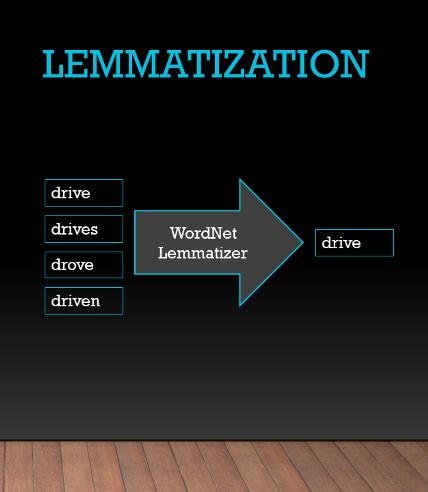

In [14]:
lemmatizer = WordNetLemmatizer()

def lemm_text(text):
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split(' '))
    return text

In [15]:
df['headline_clean'] = df['headline_clean'].apply(lemm_text)
df.head()

is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   

                                      headline_clean  
0  thirtysomething scientist unveil doomsday cloc...  
1  dem rep totally nail congress falling short ge...  
2           eat veggie  deliciously different recipe  
3       inclement weather prevents liar getting work  
4  mother come pretty close using word streaming ...

### Wizualizacja danych
Jak wygląda rozkład długości nagłówka dla tekstów sarkastycznych i niesarkastycznych?

<Axes: xlabel='is_sarcastic', ylabel='headline_clean'>

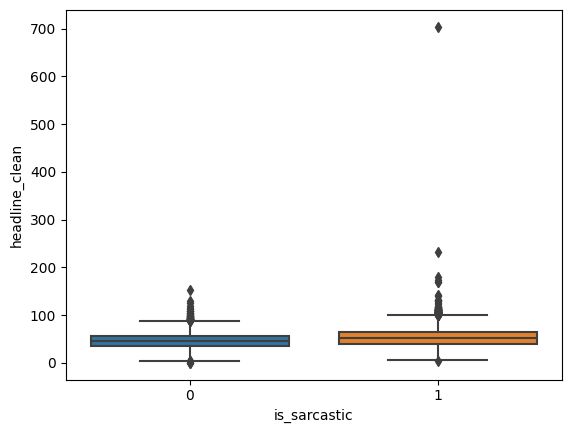

In [16]:
sns.boxplot(y=df["headline_clean"].str.len(), x=df["is_sarcastic"])

Widzimy, że średnia długość nagłówka dla tekstów sarkastycznych jest większa niż dla niesarkastycznych. Jednak ta różnica jest niewielka, przez co nie będzie miała znacznego wpływu na model.
#### Liczba rekordów ze względu na kategorię
Sprawdźmy ile jest rekordów w zbiorze danych dla każdej z kategorii.

<Axes: xlabel='is_sarcastic', ylabel='count'>

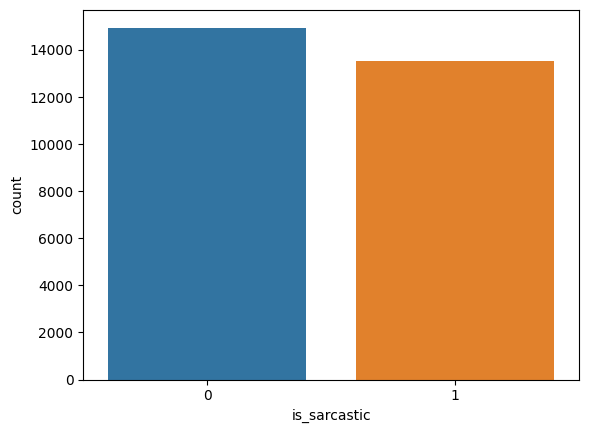

In [17]:
sns.countplot(data=df, x='is_sarcastic')

Zbiór jest bardzo zbalansowany, co jest bardzo dobre dla naszego modelu. Nie będziemy musieli się martwić o to, że model będzie bardziej skupiony na jednej z kategorii.

#### WordCloud
WordCloud to bardzo przydatne narzędzie do wizualizacji danych tekstowych. Pozwala nam na zobaczenie najczęściej występujących słów w naszym zbiorze danych. Sprawdźmy jak wygląda WordCloud dla naszego zbioru danych.
* nagłówki nie sarkastyczne:

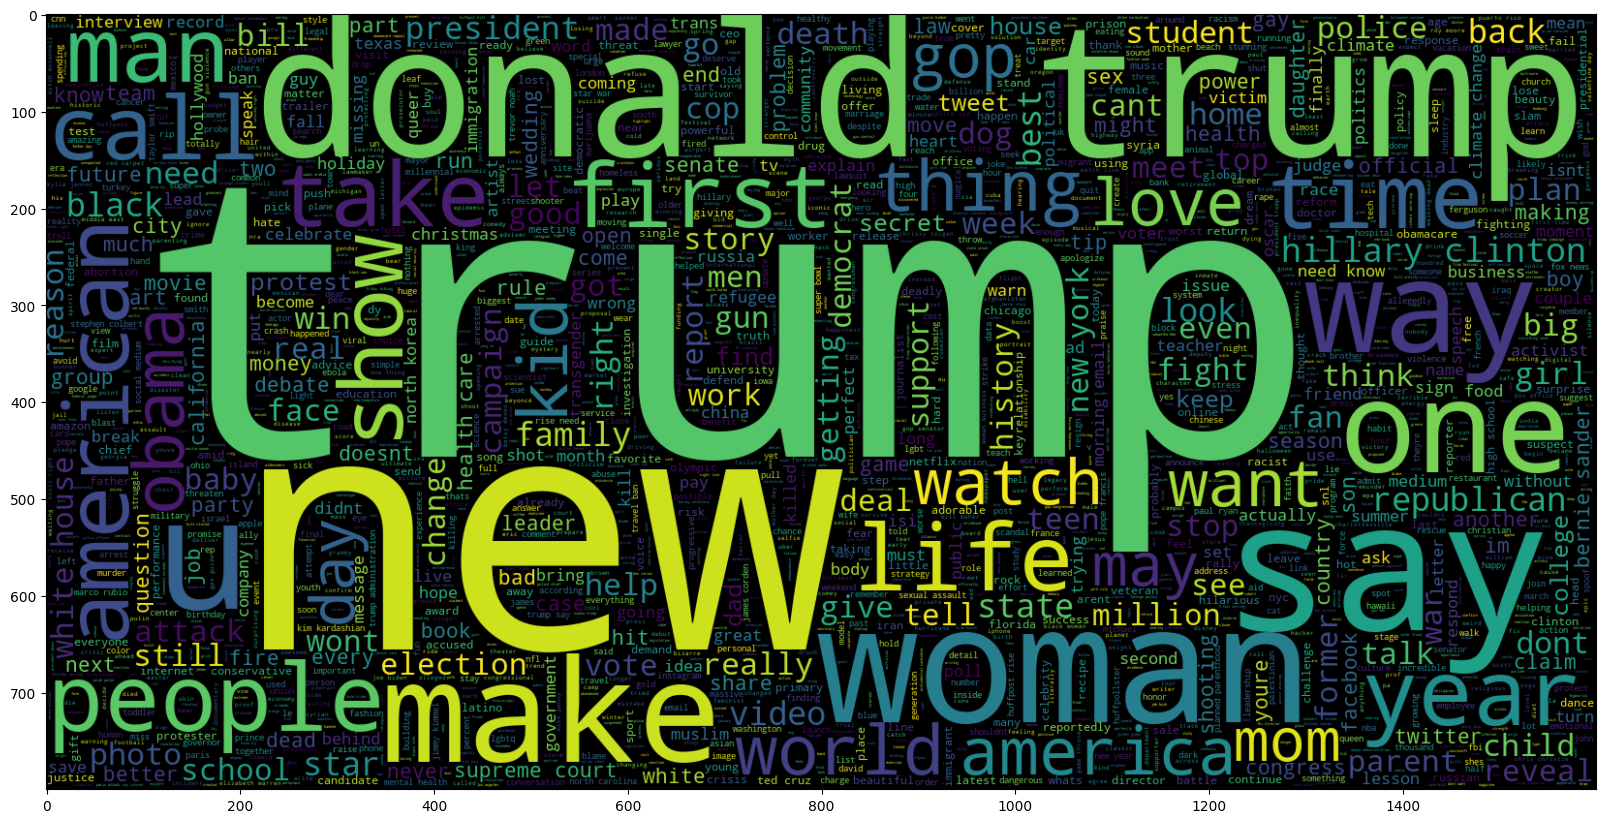

In [16]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline_clean))
plt.imshow(wc , interpolation = 'bilinear')

* nagłówki sarkastyczne:

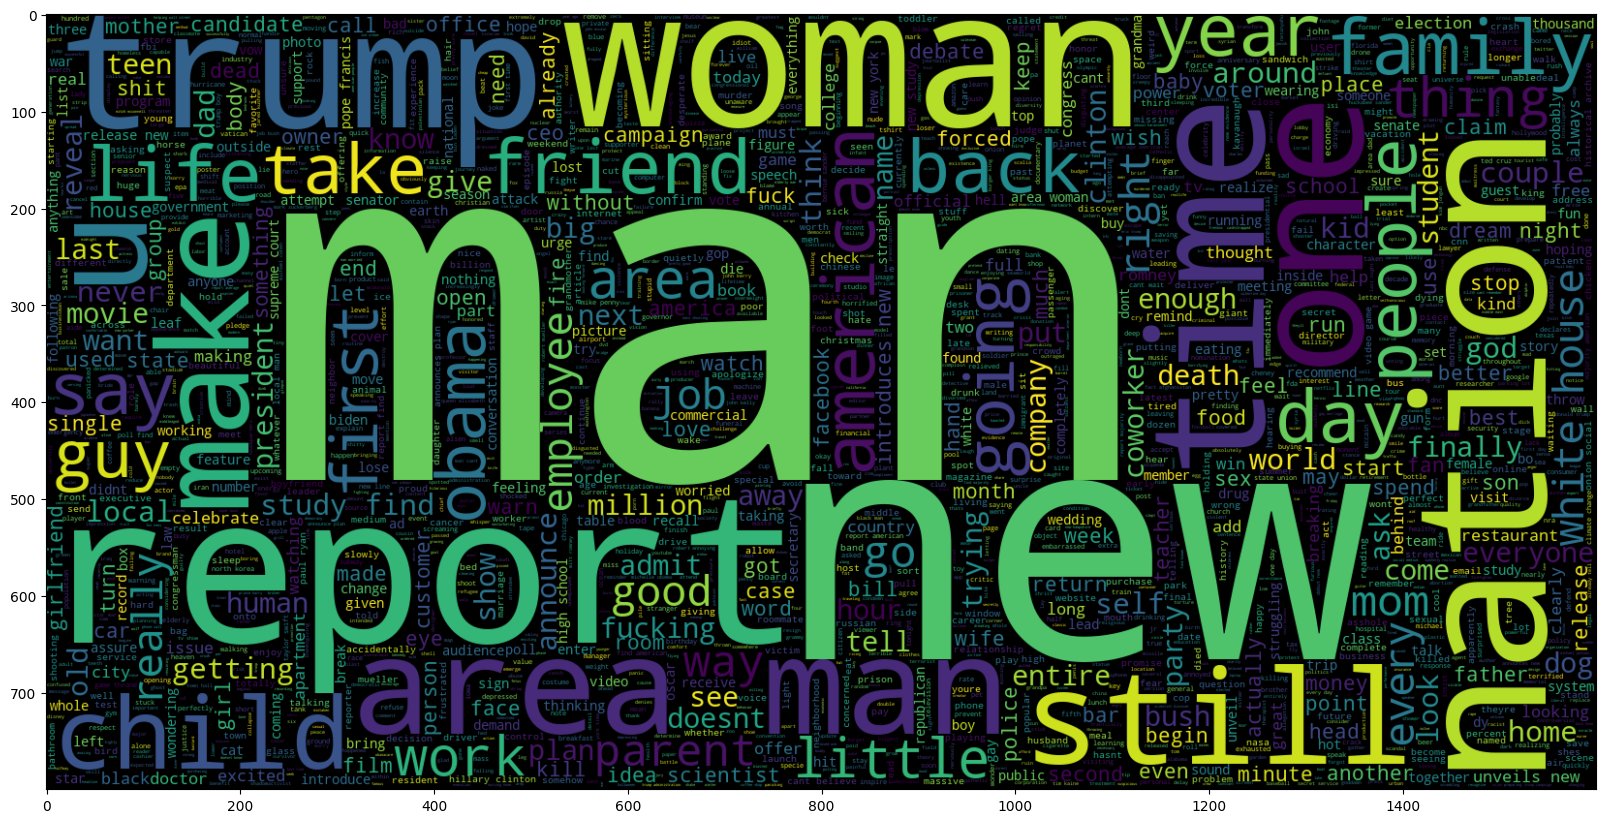

In [17]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline_clean))
plt.imshow(wc , interpolation = 'bilinear')

Wiedząć już jak prezentują się przykłady uczące i ich rozkład możemy przystąpić do kolejnych etapów.
## Tokenizacja danych

Zwektoryzujmy zebrane teksty i przygotujmy ich podział na zbiór uczący i walidacyjny.

- Jako, że mamy do czynienia z nagłówkami, które są zazwyczaj krótkie możemy zacząć ustawienia maksymalnej długości nagłówka na 10 słów
- W całym datasecie będziemy rozważać na początek 20 000 słów,
- zbiór testowy będzie zawierał 20% wszystkich przykładów.

In [18]:
headers = df['headline_clean']
labels = df['is_sarcastic']

In [19]:
maxlen = 20
test_size = 0.2
max_words = 20000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(headers)
sequences = tokenizer.texts_to_sequences(headers)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, random_state=42)

Found 25063 unique tokens.
Shape of data tensor: (28503, 20)
Shape of label tensor: (28503,)


## Definicja funkcji rysujących wykresy
Po pierwsze zdefiniujmy funkcje, które będą używane do wykreślania osiągniętych wyników:

In [20]:
import matplotlib.pyplot as plt  # library for plotting math functions: https://matplotlib.org/stable/index.html

#def plt_inline():
#    rc = plt.rcParams.copy()
#    %matplotlib inline
#    plt.rcParams.update(rc)

def PlotAccuracyComparison(acc, val_acc, lab = ''):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
    plt.figure(figsize=(15,5))
    #plt_inline()
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training accuracy for ' + lab)
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy for ' + lab)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train ' + lab, 'Test ' + lab], loc='upper left')
    plt.show()

def PlotLossComparison(loss, val_loss, lab = ''):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
    plt.figure(figsize=(15,5))
    #plt_inline()
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'bo', label='Training loss for ' + lab)
    plt.plot(epochs, val_loss, 'b', label='Validation loss for ' + lab)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train ' + lab, 'Test ' + lab], loc='upper left')
    plt.show()

def PlotTwoAccuracyComparison(acc1, val_acc1, acc2, val_acc2, lab1 = 'Model 1', lab2 = 'Model 2'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
    plt.figure(figsize=(15,5))
    #plt_inline()
    epochs = range(len(acc1))
    plt.plot(epochs, acc1, 'bo', label='Training accuracy for ' + lab1)
    plt.plot(epochs, val_acc1, 'b', label='Validation accuracy for ' + lab1)
    plt.plot(epochs, acc2, 'ro', label='Training accuracy for ' + lab2)
    plt.plot(epochs, val_acc2, 'r', label='Validation accuracy for ' + lab2)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train '+ lab1, 'Test ' + lab1, 'Train '+ lab2, 'Test ' + lab2], loc='upper left')
    plt.show()

def PlotTwoLossComparison(loss1, val_loss1, loss2, val_loss2, lab1 = 'Model 1', lab2 = 'Model 2'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
    plt.figure(figsize=(15,5))
    #plt_inline()
    epochs = range(len(loss1))
    plt.plot(epochs, loss1, 'bo', label='Training loss for ' + lab1)
    plt.plot(epochs, val_loss1, 'b', label='Validation loss for ' + lab1)
    plt.plot(epochs, loss2, 'ro', label='Training loss for ' + lab2)
    plt.plot(epochs, val_loss2, 'r', label='Validation loss for ' + lab2)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train '+ lab1, 'Test ' + lab1, 'Train '+ lab2, 'Test ' + lab2], loc='upper left')
    plt.show()

A także zdefiniujmy sobie funkcję do rysowania confussion matrix:

In [21]:
LABELS = ['Not sarcastic', 'Sarcastic']

# Define the confusion matrix for the results
def show_confusion_matrix(model):
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred)
    y_pred = y_pred.astype(int)
    y_pred = y_pred.flatten()
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
    disp.plot()
    plt.show()

## Modele
### Prosta sieć 1D convnet
W keras, używamy 1D convnet za pomocą warstwy `Conv1D`, która przyjmuje jako wejście 3D tensorów o kształcie `(samples, time, features)` i również zwraca 3D tensory o podobnym kształcie. Okno konwolucji jest 1D oknem na osi czasowej, tj. osi 1 w tensorze wejściowym.

1D convnets są strukturalnie takie same jak ich 2D odpowiedniki i mają bardzo podobny interfejs do `Conv2D`. Składają się z stosu warstw `Conv1D` i `MaxPooling1D`, w końcu kończąc się w warstwie globalnego agregowania (`GlobalMaxPooling1D`) lub warstwy `Flatten`, zmieniającej 3D wyjścia w 2D wyjścia, pozwalając na dodanie jednej lub więcej warstw `Dense` do modelu, do klasyfikacji lub regresji.

Używając sieci 1D convnet możemy sobie pozwolić na użycie większy okien konwolucji. W rzeczywistości w 3D convnet okno konwolucji 3x3 zawiera 3 * 3 = 9 wartości, a okno konwolucji 5x5 zawiera 5 * 5 = 25 wartości. W sieci 1D, okno konwolucji 7 zawiera 7 wartości, a okno konwolucji 9 zawiera 9 wartości. W związku z tym, możemy użyć większych okien konwolucji w sieciach 1D, niż w sieciach 2D, bez obaw o przeuczenie.

Więc zbudujmy prostą sieć dwuwarstwową 1D convnet zastosowaną do zadania klasyfikacji nagłówka newsa ze zbioru, który został zaprezentowany powyżej

In [49]:
model_simple_1d_3 = Sequential()
model_simple_1d_3.add(layers.Embedding(max_words, 128, input_length=maxlen))
model_simple_1d_3.add(layers.Conv1D(16, 3, activation='relu'))
model_simple_1d_3.add(layers.GlobalMaxPooling1D())
model_simple_1d_3.add(layers.Dense(1, activation='sigmoid'))

model_simple_1d_3.summary()

model_simple_1d_3.compile(optimizer=RMSprop(learning_rate=1e-4),
                                loss='binary_crossentropy',
                                metrics=['acc'])
history_model_simple_1d_3 = model_simple_1d_3.fit(X_train, y_train,
                                epochs=20,
                                batch_size=128,
                                validation_split=0.2)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 20, 128)           2560000   
                                                                 
 conv1d_3 (Conv1D)           (None, 18, 16)            6160      
                                                                 
 global_max_pooling1d_3 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,566,177
Trainable params: 2,566,177
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
143/143 [==============================] - 2s 7ms/step - loss: 0.6887 - acc: 0.5639 - val_loss: 0.6

<Figure size 640x480 with 0 Axes>

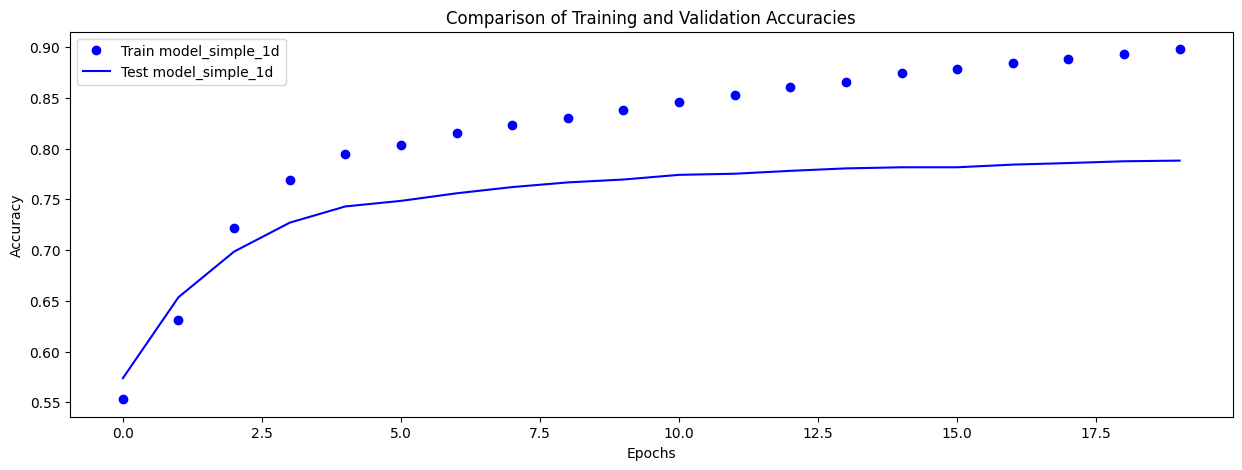

<Figure size 640x480 with 0 Axes>

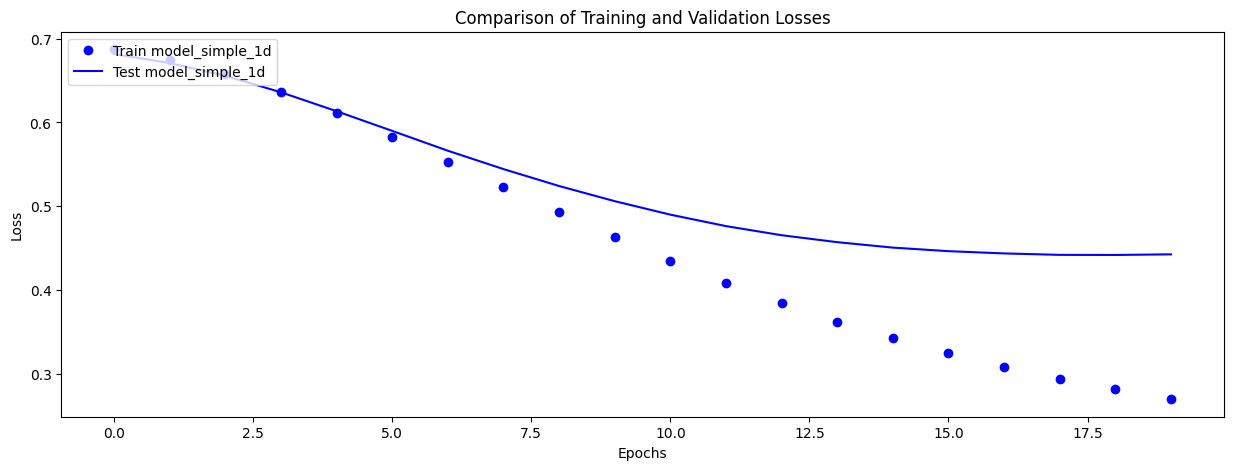

In [85]:
acc_model_simple_1d_3 = history_model_simple_1d_3.history['acc']
val_acc_model_simple_1d_3 = history_model_simple_1d_3.history['val_acc']
loss_model_simple_1d_3 = history_model_simple_1d_3.history['loss']
val_loss_model_simple_1d_3 = history_model_simple_1d_3.history['val_loss']

PlotAccuracyComparison(acc_model_simple_1d_3, val_acc_model_simple_1d_3, lab = 'model_simple_1d')
PlotLossComparison(loss_model_simple_1d_3, val_loss_model_simple_1d_3, lab = 'model_simple_1d')

179/179 [==============================] - 0s 1ms/step


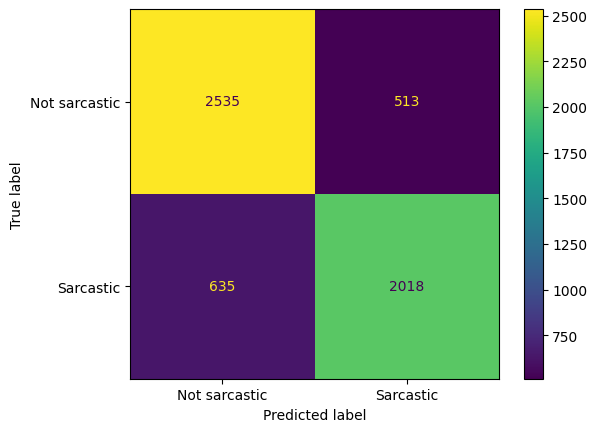

In [86]:
show_confusion_matrix(model_simple_1d_3)

Widzimy, że model zaczął się przeuczać po około 5 epokach, więc szybko. Z drugiej strony uzyskaliśmy już w miarę wysoką skuteczność wykrywania sarkazmu. Patrząc na wyniki, które osiągneliśmy wyżej, celem tego notebooka będzie osiągnięcie skuteczności większej niż 90% na zbiorze walidacyjnym/testowym. Przejdźmy do kolejnej sieci i zmieńmy tylko wielkość okna do 5, czyli połowę długości całego nagłówka. Sieć będzie przez to potrafiła patrzeć na szerszy kontekst co może mieć istotne znaczenie na wyniki, ponieważ czy coś jest sarkazmem nie zależy od jednego słowa (jak to może mieć miejsce w wykrywaniu kłamstw), ale ważny jest kontekst.

In [95]:
model_simple_1d_5 = Sequential()
model_simple_1d_5.add(layers.Embedding(max_words, 128, input_length=maxlen))
model_simple_1d_5.add(layers.Conv1D(16, 5, activation='relu'))
model_simple_1d_5.add(layers.GlobalMaxPooling1D())
model_simple_1d_5.add(layers.Dense(1, activation='sigmoid'))

model_simple_1d_5.summary()

model_simple_1d_5.compile(optimizer=RMSprop(learning_rate=1e-4),
                                loss='binary_crossentropy',
                                metrics=['acc'])
history_model_simple_1d_5 = model_simple_1d_5.fit(X_train, y_train,
                                epochs=20,
                                batch_size=128,
                                validation_split=0.2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 20, 128)           2560000   
                                                                 
 conv1d_5 (Conv1D)           (None, 16, 16)            10256     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,570,273
Trainable params: 2,570,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
143/143 [==============================] - 2s 8ms/step - loss: 0.6892 - acc: 0.5326 - val_loss: 0.6

<Figure size 640x480 with 0 Axes>

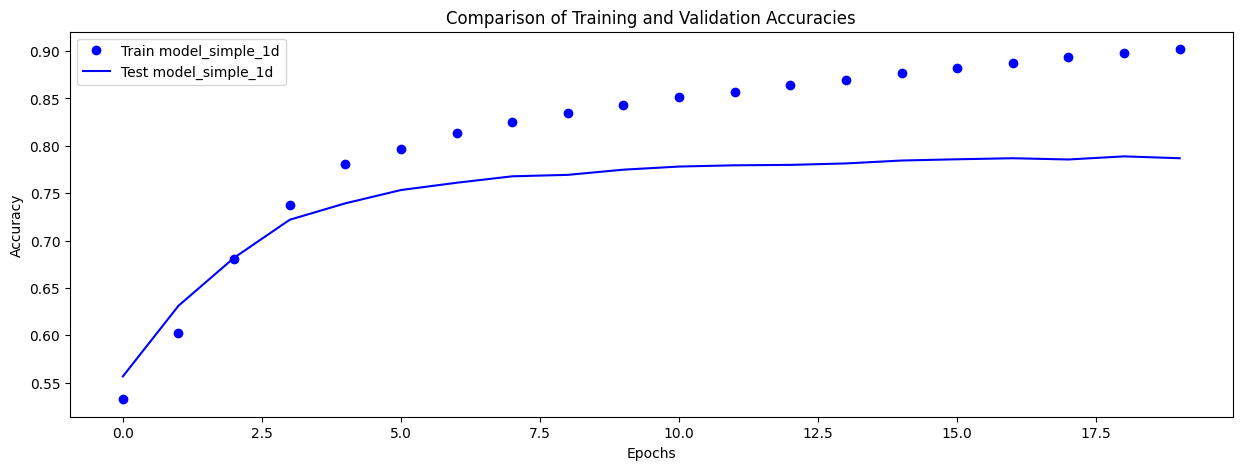

<Figure size 640x480 with 0 Axes>

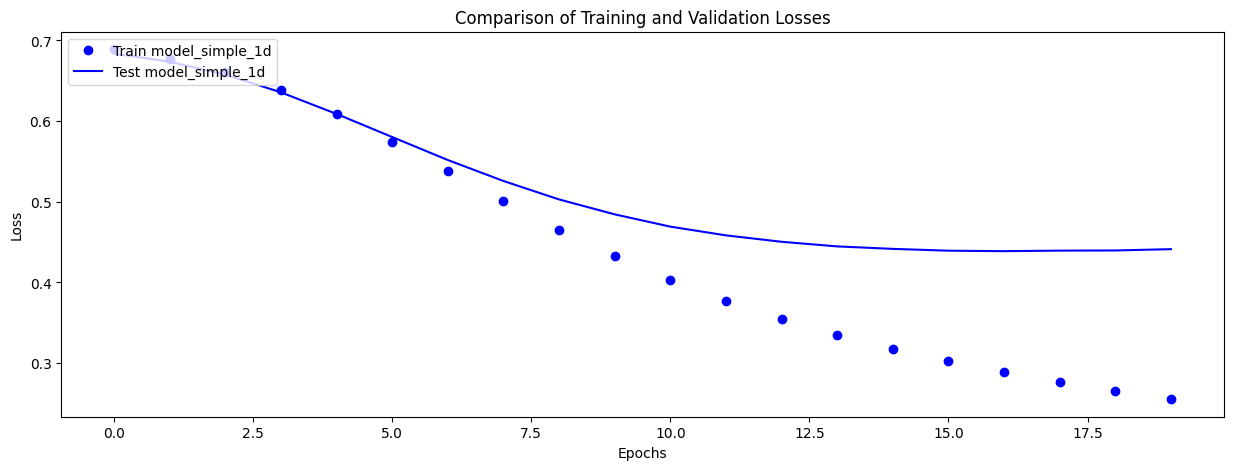

In [96]:
acc_model_simple_1d_5 = history_model_simple_1d_5.history['acc']
val_acc_model_simple_1d_5 = history_model_simple_1d_5.history['val_acc']
loss_model_simple_1d_5 = history_model_simple_1d_5.history['loss']
val_loss_model_simple_1d_5 = history_model_simple_1d_5.history['val_loss']

PlotAccuracyComparison(acc_model_simple_1d_5, val_acc_model_simple_1d_5, lab = 'model_simple_1d')
PlotLossComparison(loss_model_simple_1d_5, val_loss_model_simple_1d_5, lab = 'model_simple_1d')

179/179 [==============================] - 0s 2ms/step


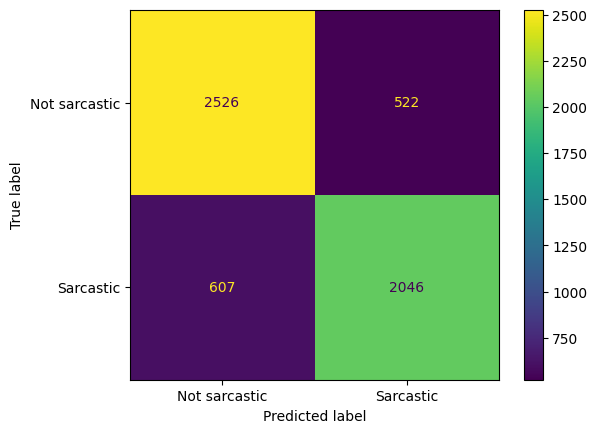

In [97]:
show_confusion_matrix(model_simple_1d_5)

Zwiększenie szerokości okna nie pomogło zbyt wiele. Uzyskaliśmy podobny wynik na zbiorze walidacyjnym i dalej naszym problem jest overfitting.

Zostańmy jeszcze przy prostych sieciach 1D i spróbujmy ją jeszcze trochę rozbudować i sprawdzić co się stanie:
- zwiększmy output size warstwy Embedding
- Dodajmy jedną warstwę conv1D z mniejszym rozmiarem okna (5->3)

In [98]:
model_extended_1d_3 = Sequential()
model_extended_1d_3.add(layers.Embedding(max_words, 256, input_length=maxlen))
model_extended_1d_3.add(layers.Conv1D(16, 3, activation='relu'))
model_extended_1d_3.add(layers.MaxPooling1D(3))
model_extended_1d_3.add(layers.Conv1D(16, 3, activation='relu'))
model_extended_1d_3.add(layers.GlobalMaxPooling1D())
model_extended_1d_3.add(layers.Dense(1, activation='sigmoid'))

model_extended_1d_3.summary()

model_extended_1d_3.compile(optimizer=RMSprop(learning_rate=1e-4),
                                loss='binary_crossentropy',
                                metrics=['acc'])
history_model_extended_1d_3 = model_extended_1d_3.fit(X_train, y_train,
                                epochs=20,
                                batch_size=128,
                                validation_split=0.2)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 20, 256)           5120000   
                                                                 
 conv1d_6 (Conv1D)           (None, 18, 16)            12304     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 6, 16)            0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 4, 16)             784       
                                                                 
 global_max_pooling1d_5 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 1)                

<Figure size 640x480 with 0 Axes>

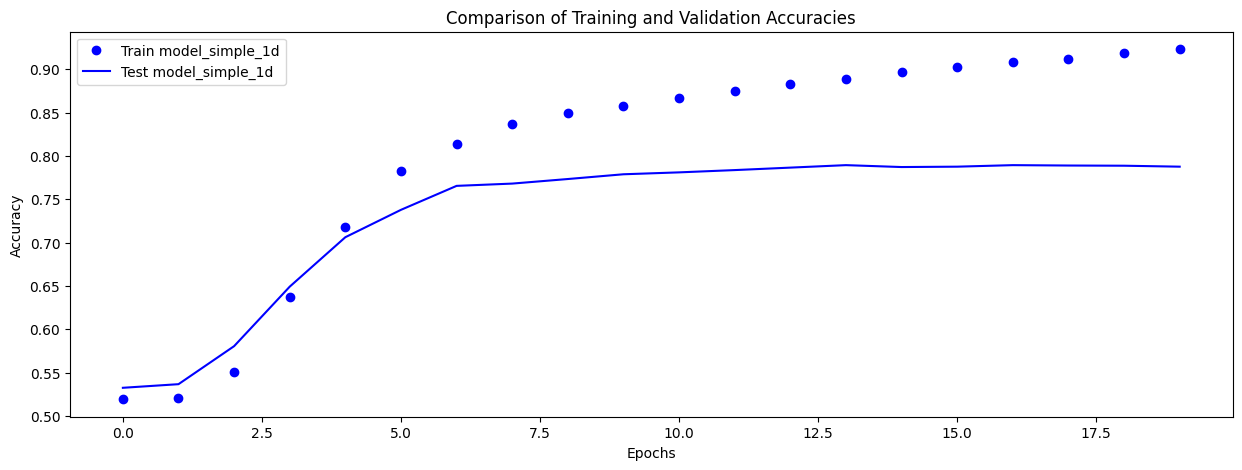

<Figure size 640x480 with 0 Axes>

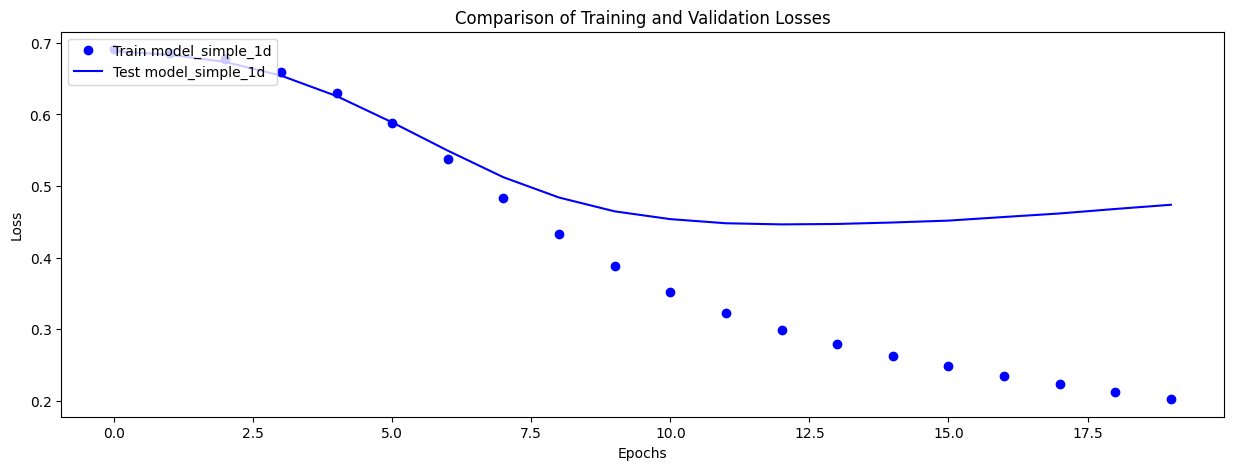

In [99]:
acc_extended_simple_1d_3 = history_model_extended_1d_3.history['acc']
val_acc_model_extended_1d_3 = history_model_extended_1d_3.history['val_acc']
loss_model_extended_1d_3 = history_model_extended_1d_3.history['loss']
val_loss_model_extended_1d_3 = history_model_extended_1d_3.history['val_loss']

PlotAccuracyComparison(acc_extended_simple_1d_3, val_acc_model_extended_1d_3, lab = 'model_simple_1d')
PlotLossComparison(loss_model_extended_1d_3, val_loss_model_extended_1d_3, lab = 'model_simple_1d')

179/179 [==============================] - 0s 1ms/step


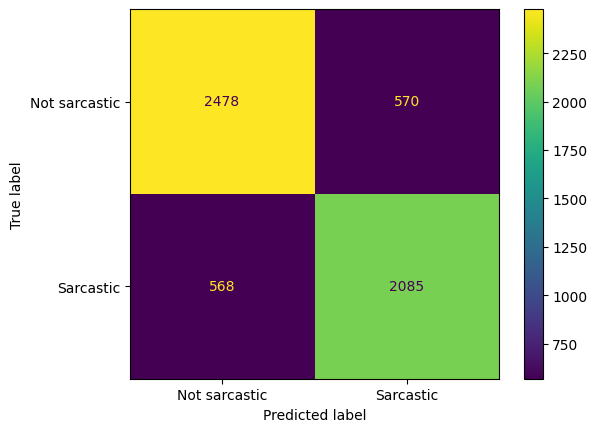

In [100]:
show_confusion_matrix(model_extended_1d_3)

Zwiększając złożoność prostego modelu zwiększył się overfitting. Widzimy więc, że sieci conv1d nie są wystarczające do naszego problemu wykrywania sarkazmu

## Rekurencyjne sieci neuronowe
Do rozwikłania problemu wykrywania sarkazamu w nagłówkach wiadomości spróbujmy użyć podstawowej sieci rekurencyjnej, gdzie nagłówek będzie przypisany do 0 (nie sarkastyczny), a do 1, gdy będzie sarkastyczny. Dlatego jak wcześniej potrzebujemy pojedynczą komórkę na wyjściu.

Z racji, że uczenie niektórych sieci rekurencyjnych może trwać długo przez to, że nie wykorzystują karty graficznej, będziemy zapisywać modele do folderu `models`:

In [28]:
# The path to store trained models
models_dir = 'models/'
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

Zaczniemy od najprostszej sieci. Zostawimy na początku warstwę `Embedding`, a gdzie wcześniej mieliśmy `conv1D` wstawimy `SimpleRNN`:

In [102]:
modelSarcasmSimpleRNN = Sequential()
modelSarcasmSimpleRNN.add(layers.Embedding(max_words, 32, input_length=maxlen))
modelSarcasmSimpleRNN.add(layers.SimpleRNN(32))
modelSarcasmSimpleRNN.add(layers.Dense(1, activation='sigmoid'))

modelSarcasmSimpleRNN.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
historySarcasmSimpleRNN = modelSarcasmSimpleRNN.fit(X_train, y_train,
                                              epochs = 20,
                                              batch_size = 256,
                                              validation_split = 0.2)

modelSarcasmSimpleRNN.save(models_dir + 'Sarcasm_SimpleRNN.h5')

Epoch 1/20
72/72 [==============================] - 3s 28ms/step - loss: 0.6196 - acc: 0.6486 - val_loss: 0.5159 - val_acc: 0.7509
Epoch 2/20
72/72 [==============================] - 2s 24ms/step - loss: 0.4092 - acc: 0.8190 - val_loss: 0.4647 - val_acc: 0.7818
Epoch 3/20
72/72 [==============================] - 2s 25ms/step - loss: 0.2981 - acc: 0.8797 - val_loss: 0.4619 - val_acc: 0.7891
Epoch 4/20
72/72 [==============================] - 2s 24ms/step - loss: 0.2243 - acc: 0.9144 - val_loss: 0.4833 - val_acc: 0.7902
Epoch 5/20
72/72 [==============================] - 2s 26ms/step - loss: 0.1763 - acc: 0.9342 - val_loss: 0.5101 - val_acc: 0.7838
Epoch 6/20
72/72 [==============================] - 2s 24ms/step - loss: 0.1277 - acc: 0.9537 - val_loss: 0.5596 - val_acc: 0.7860
Epoch 7/20
72/72 [==============================] - 2s 25ms/step - loss: 0.0968 - acc: 0.9669 - val_loss: 0.6022 - val_acc: 0.7770
Epoch 8/20
72/72 [==============================] - 2s 25ms/step - loss: 0.0713 - a

<Figure size 640x480 with 0 Axes>

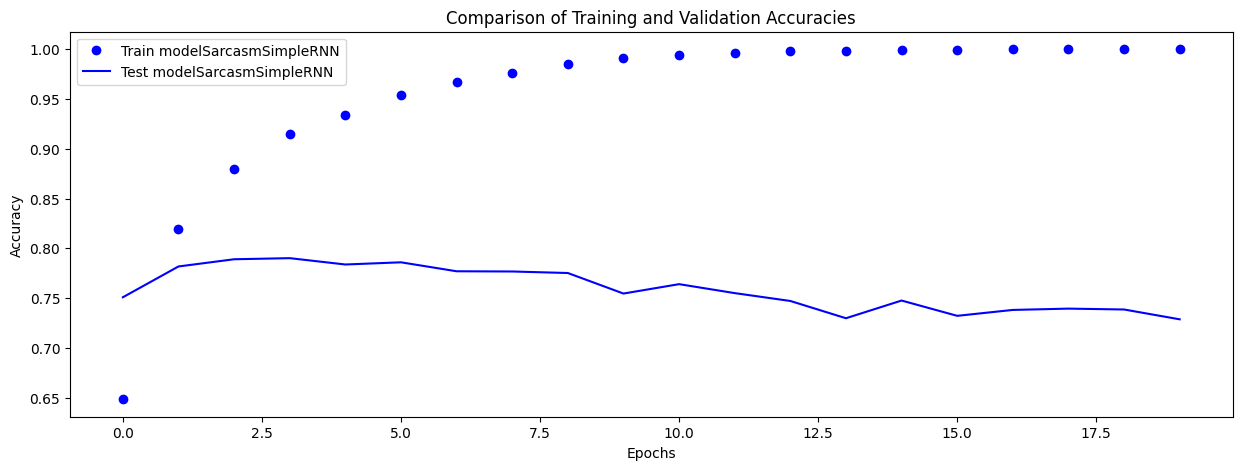

<Figure size 640x480 with 0 Axes>

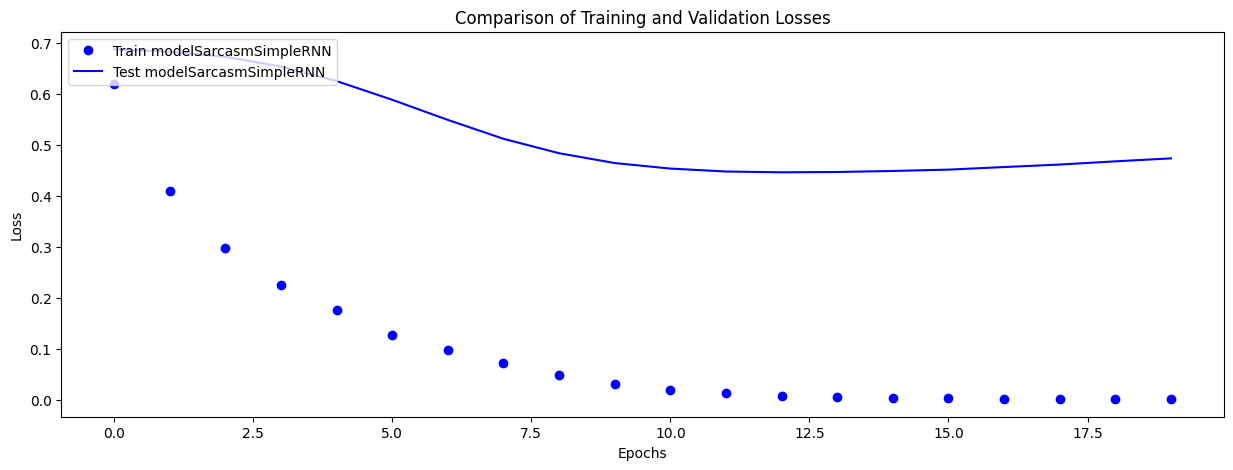

In [103]:
acc_SarcasmSimpleRNN = historySarcasmSimpleRNN.history['acc']
val_acc_SarcasmSimpleRNN = historySarcasmSimpleRNN.history['val_acc']
loss_SarcasmSimpleRNN = historySarcasmSimpleRNN.history['loss']
val_loss_SarcasmSimpleRNN = historySarcasmSimpleRNN.history['val_loss']

PlotAccuracyComparison(acc_SarcasmSimpleRNN, val_acc_SarcasmSimpleRNN, lab = 'modelSarcasmSimpleRNN')
PlotLossComparison(loss_SarcasmSimpleRNN, val_loss_SarcasmSimpleRNN, lab = 'modelSarcasmSimpleRNN')

179/179 [==============================] - 1s 4ms/step


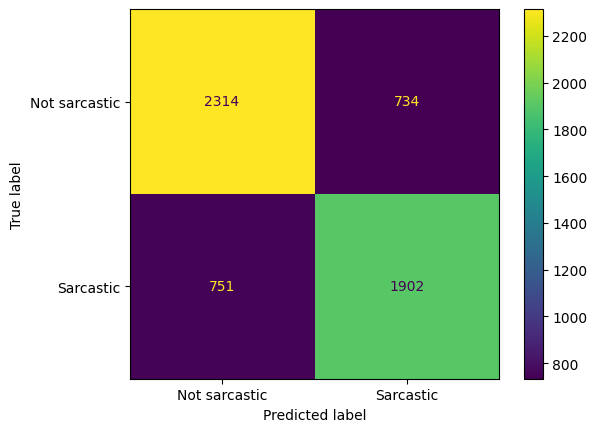

In [104]:
show_confusion_matrix(modelSarcasmSimpleRNN)

Sieć bardzo szybko zaczęła się przeuczać, widzimy, że ten model jest nieodpowiedni dla tego problemu. Model zamiast zaczął się uczyć danych zamiast je uogulniać. Zwiększenie złożoności modelu spowoduje jeszcze większy overfitting. Ale zobaczmy dokładnie co się stanie, więc spróbujmy zwiększyć rozmiar wyjścia z warstwy Embedding zostawiając resztę parametrów.

In [107]:
modelSarcasmSimpleRNN = Sequential()
modelSarcasmSimpleRNN.add(layers.Embedding(max_words, 256, input_length=maxlen))
modelSarcasmSimpleRNN.add(layers.SimpleRNN(64))
modelSarcasmSimpleRNN.add(layers.Dense(8))
modelSarcasmSimpleRNN.add(layers.Dense(1, activation='sigmoid'))

modelSarcasmSimpleRNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
historySarcasmSimpleRNN = modelSarcasmSimpleRNN.fit(X_train, y_train,
                                              epochs = 20,
                                              batch_size = 256,
                                              validation_split = 0.2)

modelSarcasmSimpleRNN.save(models_dir + 'Sarcasm_SimpleRNN.h5')

Epoch 1/20
72/72 [==============================] - 3s 33ms/step - loss: 0.5822 - acc: 0.6738 - val_loss: 0.4547 - val_acc: 0.7805
Epoch 2/20
72/72 [==============================] - 2s 28ms/step - loss: 0.1998 - acc: 0.9241 - val_loss: 0.5366 - val_acc: 0.7678
Epoch 3/20
72/72 [==============================] - 2s 29ms/step - loss: 0.0471 - acc: 0.9848 - val_loss: 0.7209 - val_acc: 0.7661
Epoch 4/20
72/72 [==============================] - 2s 29ms/step - loss: 0.0125 - acc: 0.9969 - val_loss: 0.8954 - val_acc: 0.7606
Epoch 5/20
72/72 [==============================] - 2s 29ms/step - loss: 0.0032 - acc: 0.9995 - val_loss: 0.9983 - val_acc: 0.7573
Epoch 6/20
72/72 [==============================] - 2s 29ms/step - loss: 0.0013 - acc: 0.9998 - val_loss: 1.0724 - val_acc: 0.7615
Epoch 7/20
72/72 [==============================] - 2s 29ms/step - loss: 8.9619e-04 - acc: 0.9999 - val_loss: 1.1292 - val_acc: 0.7593
Epoch 8/20
72/72 [==============================] - 2s 30ms/step - loss: 7.1124

<Figure size 640x480 with 0 Axes>

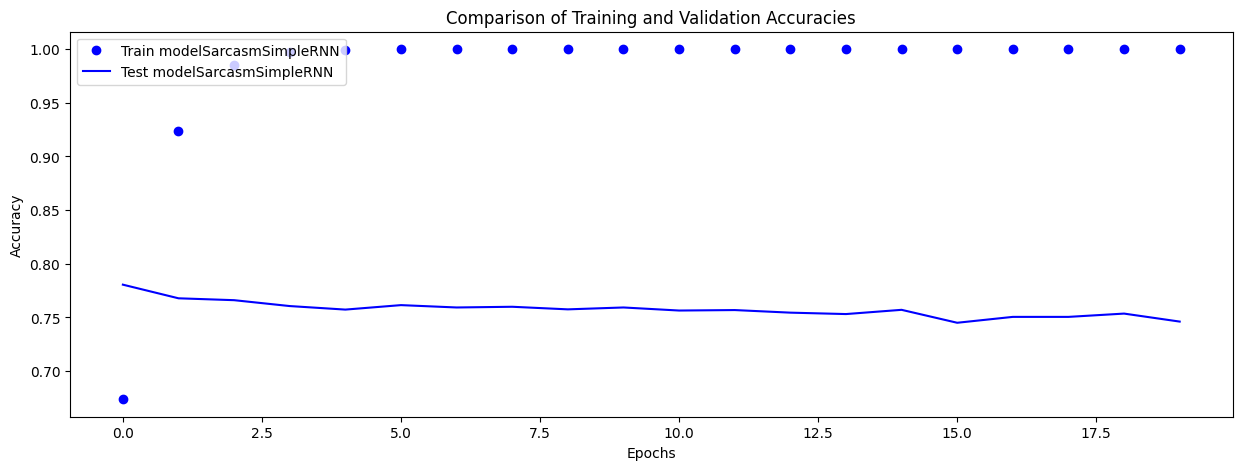

<Figure size 640x480 with 0 Axes>

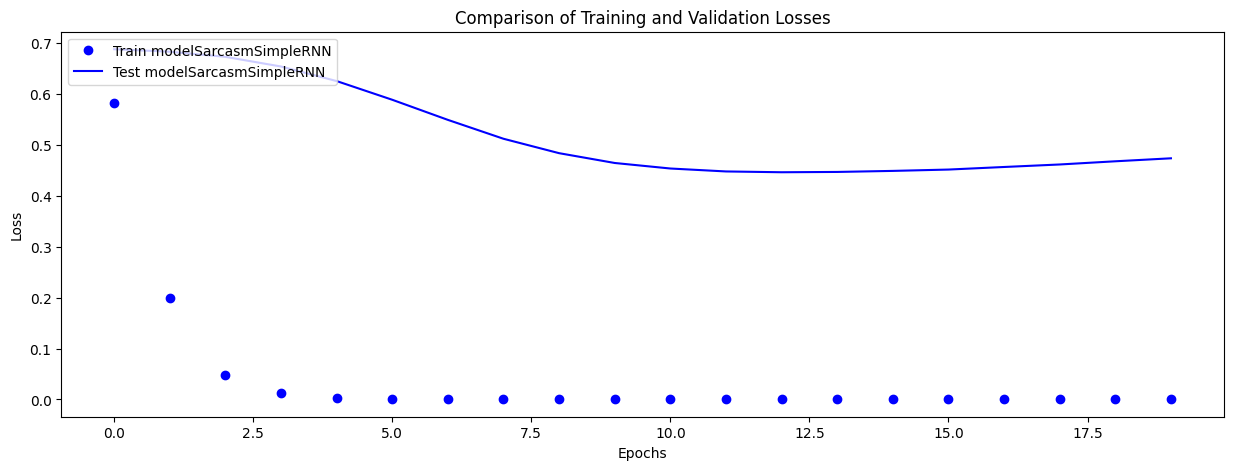

In [108]:
acc_SarcasmSimpleRNN = historySarcasmSimpleRNN.history['acc']
val_acc_SarcasmSimpleRNN = historySarcasmSimpleRNN.history['val_acc']
loss_SarcasmSimpleRNN = historySarcasmSimpleRNN.history['loss']
val_loss_SarcasmSimpleRNN = historySarcasmSimpleRNN.history['val_loss']

PlotAccuracyComparison(acc_SarcasmSimpleRNN, val_acc_SarcasmSimpleRNN, lab = 'modelSarcasmSimpleRNN')
PlotLossComparison(loss_SarcasmSimpleRNN, val_loss_SarcasmSimpleRNN, lab = 'modelSarcasmSimpleRNN')

179/179 [==============================] - 1s 4ms/step


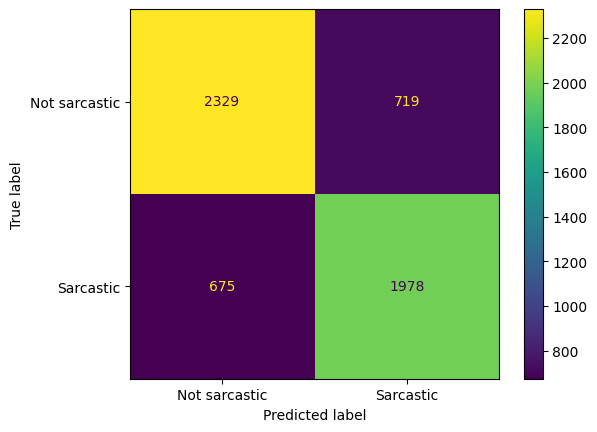

In [109]:
show_confusion_matrix(modelSarcasmSimpleRNN)

Tak jak myśleliśmy model przestaje uogualniać dane. Poprzednio używaliśmy prostych sieci 1D, gdzie uzyskaliśmy około 80% skuteczności na zbiorze testowym, więc były lepsze niż te uzyskane teraz za pomocą prostej warstwy `SimpleRNN`. Prosta sieć 1D jak na razie się w miarę sprawdziła. Jednak overfittują szybko po rozpoczęciu uczenia. Dlatego w dalszej części będziemy chcieli spróbować wytrenować sieci, które sprawdzają się lepiej dla przetwarzania tekstów
## Sieci używające warstw LSTM 
Teraz spróbujmy wytrenować model, na który składać się będą warstwy `LSTM`, które zazwyczaj lepiej sprawdzają się dla tekstów. Skoro mamy do czynienia z krótkimi tekstami spróbujmy zmniejszyć złożoność  modelu, gdyż poprzednie nie uogulniały modelu lecz się go uczyły na pamięć

In [115]:

modelSarcasmLSTM = Sequential()
modelSarcasmLSTM.add(layers.Embedding(max_words, 16)) #32
modelSarcasmLSTM.add(layers.LSTM(8)) 
modelSarcasmLSTM.add(layers.Dense(1, activation='sigmoid'))

modelSarcasmLSTM.compile(optimizer=RMSprop(learning_rate=1e-4),
                      loss='binary_crossentropy',
                      metrics=['acc'])
historySarcasmLSTM = modelSarcasmLSTM.fit(X_train, y_train,
                                    epochs=20,
                                    batch_size=256,
                                    validation_split=0.2)

modelSarcasmLSTM.save(models_dir + 'Sarcasm_LSTM.h5')

Epoch 1/20
72/72 [==============================] - 3s 15ms/step - loss: 0.6932 - acc: 0.4959 - val_loss: 0.6922 - val_acc: 0.5477
Epoch 2/20
72/72 [==============================] - 1s 9ms/step - loss: 0.6912 - acc: 0.5463 - val_loss: 0.6904 - val_acc: 0.5499
Epoch 3/20
72/72 [==============================] - 1s 9ms/step - loss: 0.6891 - acc: 0.5323 - val_loss: 0.6882 - val_acc: 0.5391
Epoch 4/20
72/72 [==============================] - 1s 9ms/step - loss: 0.6865 - acc: 0.5265 - val_loss: 0.6856 - val_acc: 0.5389
Epoch 5/20
72/72 [==============================] - 1s 9ms/step - loss: 0.6833 - acc: 0.5305 - val_loss: 0.6825 - val_acc: 0.5415
Epoch 6/20
72/72 [==============================] - 1s 10ms/step - loss: 0.6795 - acc: 0.5354 - val_loss: 0.6787 - val_acc: 0.5468
Epoch 7/20
72/72 [==============================] - 1s 9ms/step - loss: 0.6747 - acc: 0.5445 - val_loss: 0.6742 - val_acc: 0.5560
Epoch 8/20
72/72 [==============================] - 1s 9ms/step - loss: 0.6690 - acc: 0.

<Figure size 640x480 with 0 Axes>

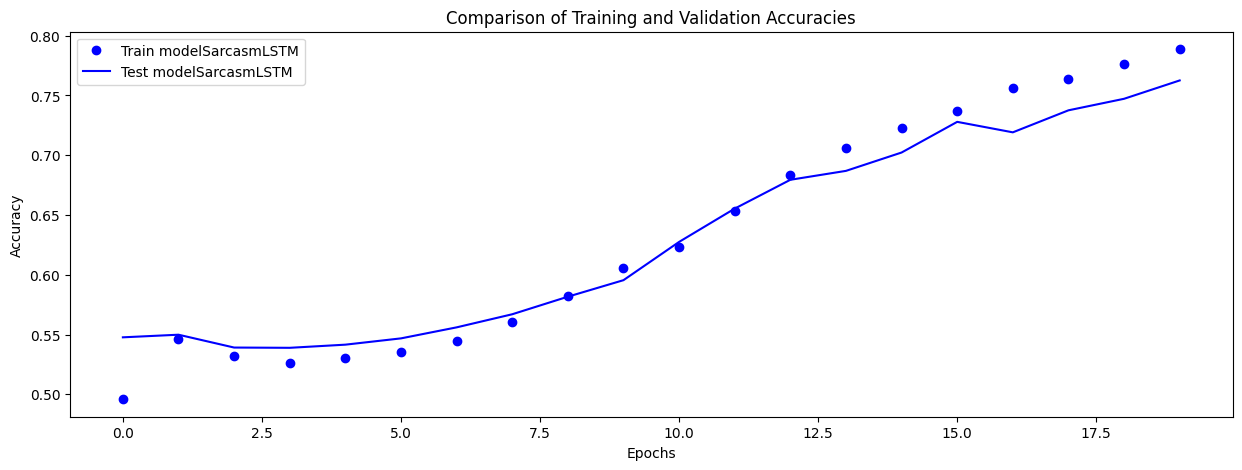

<Figure size 640x480 with 0 Axes>

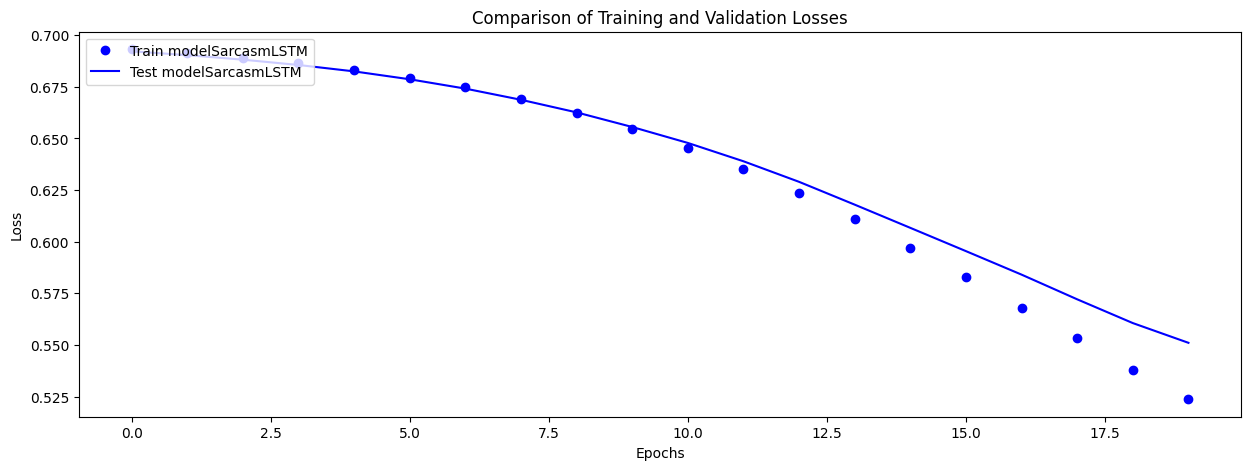

In [116]:
acc_SarcasmLSTM = historySarcasmLSTM.history['acc']
val_acc_SarcasmLSTM = historySarcasmLSTM.history['val_acc']
loss_SarcasmLSTM = historySarcasmLSTM.history['loss']
val_loss_SarcasmLSTM = historySarcasmLSTM.history['val_loss']

PlotAccuracyComparison(acc_SarcasmLSTM, val_acc_SarcasmLSTM, lab = 'modelSarcasmLSTM')
PlotLossComparison(loss_SarcasmLSTM, val_loss_SarcasmLSTM, lab = 'modelSarcasmLSTM')

Widzimy, że dane rosną w miarę równo. Sprawdźmy co się dzieje z procesem uczenia po 20 epokach i uruchommy model na 100 epok 

In [118]:

modelSarcasmLSTM = Sequential()
modelSarcasmLSTM.add(layers.Embedding(max_words, 16)) #32
modelSarcasmLSTM.add(layers.LSTM(8)) #32  # https://keras.io/api/layers/recurrent_layers/lstm/
#modelIMDBLSTM.add(Dropout(0.125)) #+
modelSarcasmLSTM.add(layers.Dense(1, activation='sigmoid'))

modelSarcasmLSTM.compile(optimizer=RMSprop(learning_rate=1e-4),
                      loss='binary_crossentropy',
                      metrics=['acc'])
historySarcasmLSTM = modelSarcasmLSTM.fit(X_train, y_train,
                                    epochs=100,
                                    batch_size=256,
                                    validation_split=0.2)

modelSarcasmLSTM.save(models_dir + 'Sarcasm_LSTM.h5')

Epoch 1/100
72/72 [==============================] - 3s 15ms/step - loss: 0.6931 - acc: 0.5029 - val_loss: 0.6923 - val_acc: 0.5453
Epoch 2/100
72/72 [==============================] - 1s 9ms/step - loss: 0.6914 - acc: 0.5297 - val_loss: 0.6906 - val_acc: 0.5341
Epoch 3/100
72/72 [==============================] - 1s 9ms/step - loss: 0.6897 - acc: 0.5204 - val_loss: 0.6888 - val_acc: 0.5332
Epoch 4/100
72/72 [==============================] - 1s 9ms/step - loss: 0.6876 - acc: 0.5200 - val_loss: 0.6868 - val_acc: 0.5337
Epoch 5/100
72/72 [==============================] - 1s 9ms/step - loss: 0.6852 - acc: 0.5212 - val_loss: 0.6844 - val_acc: 0.5350
Epoch 6/100
72/72 [==============================] - 1s 10ms/step - loss: 0.6823 - acc: 0.5243 - val_loss: 0.6816 - val_acc: 0.5380
Epoch 7/100
72/72 [==============================] - 1s 9ms/step - loss: 0.6787 - acc: 0.5302 - val_loss: 0.6782 - val_acc: 0.5440
Epoch 8/100
72/72 [==============================] - 1s 9ms/step - loss: 0.6743 -

<Figure size 640x480 with 0 Axes>

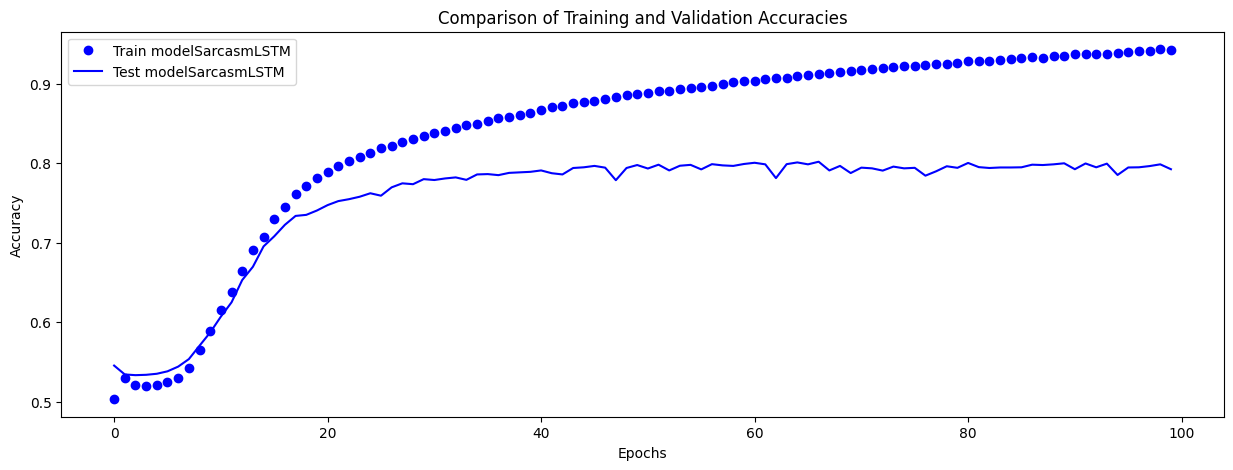

<Figure size 640x480 with 0 Axes>

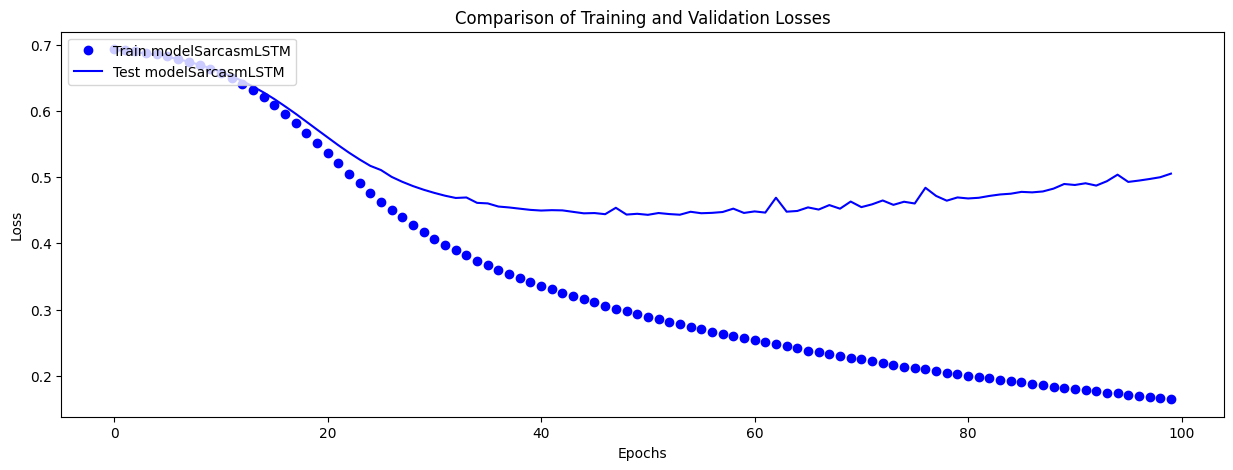

In [119]:
acc_SarcasmLSTM = historySarcasmLSTM.history['acc']
val_acc_SarcasmLSTM = historySarcasmLSTM.history['val_acc']
loss_SarcasmLSTM = historySarcasmLSTM.history['loss']
val_loss_SarcasmLSTM = historySarcasmLSTM.history['val_loss']

PlotAccuracyComparison(acc_SarcasmLSTM, val_acc_SarcasmLSTM, lab = 'modelSarcasmLSTM')
PlotLossComparison(loss_SarcasmLSTM, val_loss_SarcasmLSTM, lab = 'modelSarcasmLSTM')

Skuteczność na zbiorze walidacyjnym nie znacznie się poprawiła. Jednak naszym problemem jest overfitting

### Warstwa osadzeń - Glove
Warstwy osadzeń słów są formą prezentacji słów, która odwzorowuje to co rozumie człowiek na to co jest zrozumiałe dla komputera. Dotychczas nasz model sam się uczył wag dla tej warstwy. Od tego momentu sprawdzimy jak zachowają się nasze wyniki dostarczając modeli większej ilości informacji na początek. W tym celu wykorzystamy osadzenia słów Glove dla wymiaru 200.
#### Wczytanie GloVe 200D embeddings

In [25]:
glove_dir = '../../common/glove' 

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'), encoding ="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Zbudowanie macierzy osadzenia, która będziemy mogli załadować do warstwy Embedding

In [26]:
embedding_dim = 300

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

Teraz nauczymy jeszcze raz najlepsze modele z każdego rodzaju sieci, czyli:
- 1D convnet,
- simple RNN,
- LSTM,
- GRU
I porównamy te wyniki w zależności czy były uczone bez/z warstwą osadzeń GloVe. Pozwoli nam to ocenić, w którym kierunku dalej podążać
### Modele z warstwą osadzeń słów GloVe
* 1D convnet

In [40]:
model_simple_1d_3_glove = Sequential()
model_simple_1d_3_glove.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model_simple_1d_3_glove.add(layers.Conv1D(16, 3, activation='relu'))
model_simple_1d_3_glove.add(layers.GlobalMaxPooling1D())
model_simple_1d_3_glove.add(layers.Dense(1, activation='sigmoid'))

model_simple_1d_3_glove.summary()

model_simple_1d_3_glove.layers[0].set_weights([embedding_matrix])
model_simple_1d_3_glove.layers[0].trainable = False

model_simple_1d_3_glove.compile(optimizer=RMSprop(learning_rate=1e-4),
                                loss='binary_crossentropy',
                                metrics=['acc'])
history_model_simple_1d_3_glove = model_simple_1d_3_glove.fit(X_train, y_train,
                                epochs=20,
                                batch_size=128,
                                validation_split=0.2)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 20, 300)           6000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 18, 16)            14416     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6,014,433
Trainable params: 6,014,433
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
143/143 [==============================] - 2s 6ms/step - loss: 0.6901 - acc: 0.5466 - val_loss: 0.6

<Figure size 640x480 with 0 Axes>

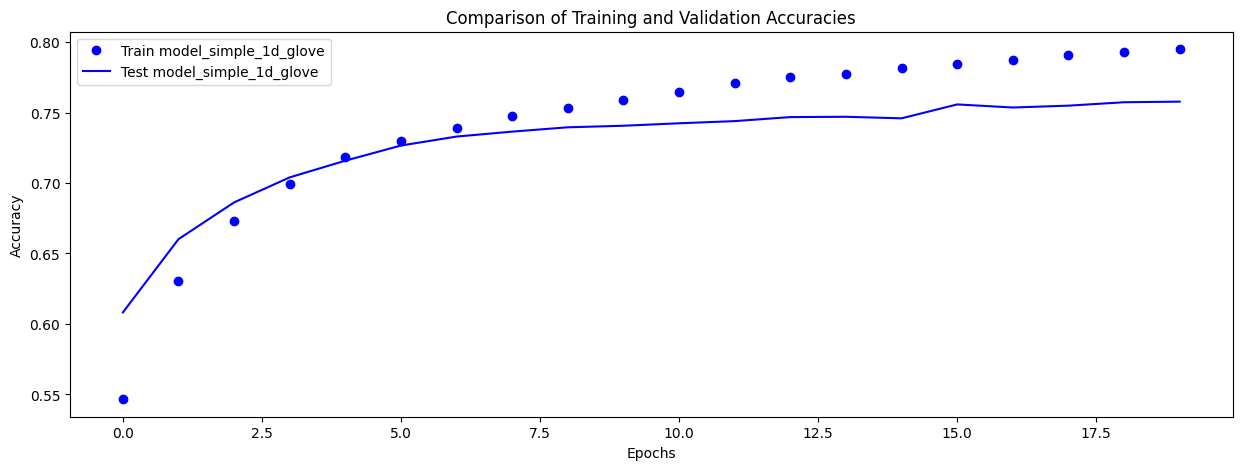

<Figure size 640x480 with 0 Axes>

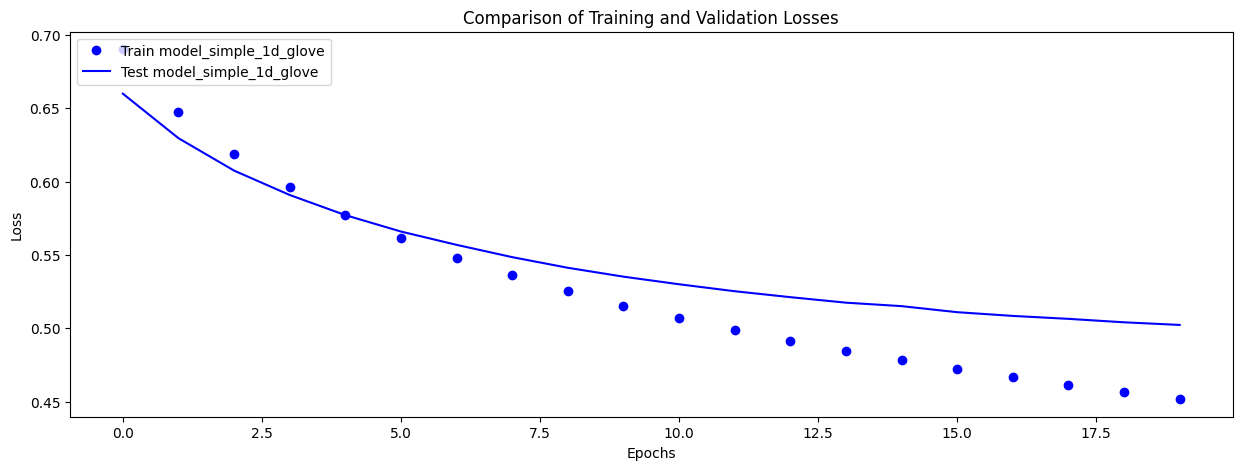

In [41]:
acc_model_simple_1d_3_glove = history_model_simple_1d_3_glove.history['acc']
val_acc_model_simple_1d_3_glove = history_model_simple_1d_3_glove.history['val_acc']
loss_model_simple_1d_3_glove = history_model_simple_1d_3_glove.history['loss']
val_loss_model_simple_1d_3_glove = history_model_simple_1d_3_glove.history['val_loss']

PlotAccuracyComparison(acc_model_simple_1d_3_glove, val_acc_model_simple_1d_3_glove, lab = 'model_simple_1d_glove')
PlotLossComparison(loss_model_simple_1d_3_glove, val_loss_model_simple_1d_3_glove, lab = 'model_simple_1d_glove')

179/179 [==============================] - 0s 1ms/step


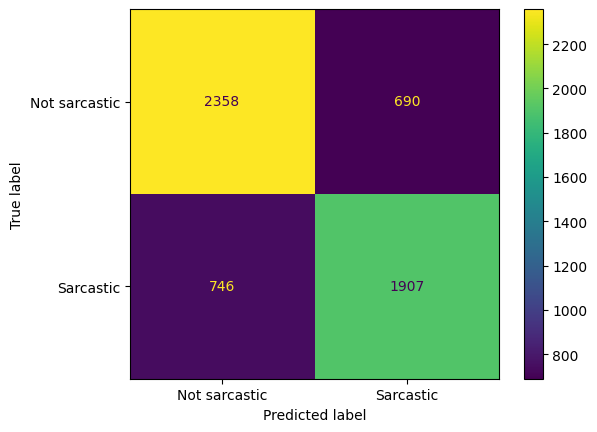

In [42]:
show_confusion_matrix(model_simple_1d_3_glove)

* simple RNN

In [43]:
modelSarcasmSimpleRNN_glove = Sequential()
modelSarcasmSimpleRNN_glove.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
modelSarcasmSimpleRNN_glove.add(layers.SimpleRNN(32))
modelSarcasmSimpleRNN_glove.add(layers.Dense(1, activation='sigmoid'))

modelSarcasmSimpleRNN_glove.summary()

modelSarcasmSimpleRNN_glove.layers[0].set_weights([embedding_matrix])
modelSarcasmSimpleRNN_glove.layers[0].trainable = False

modelSarcasmSimpleRNN_glove.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
historySarcasmSimpleRNN_glove = modelSarcasmSimpleRNN_glove.fit(X_train, y_train,
                                              epochs = 20,
                                              batch_size = 256,
                                              validation_split = 0.2)

modelSarcasmSimpleRNN_glove.save(models_dir + 'Sarcasm_SimpleRNN_glove.h5')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 20, 300)           6000000   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                10656     
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,010,689
Trainable params: 6,010,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
72/72 [==============================] - 3s 25ms/step - loss: 0.6365 - acc: 0.6370 - val_loss: 0.5697 - val_acc: 0.7128
Epoch 2/20
72/72 [==============================] - 2s 22ms/step - loss: 0.5487 - acc: 0.7238 - val_loss: 0.5607 - val_acc: 0.7165
Epoch 3/20
72/72 [============================

<Figure size 640x480 with 0 Axes>

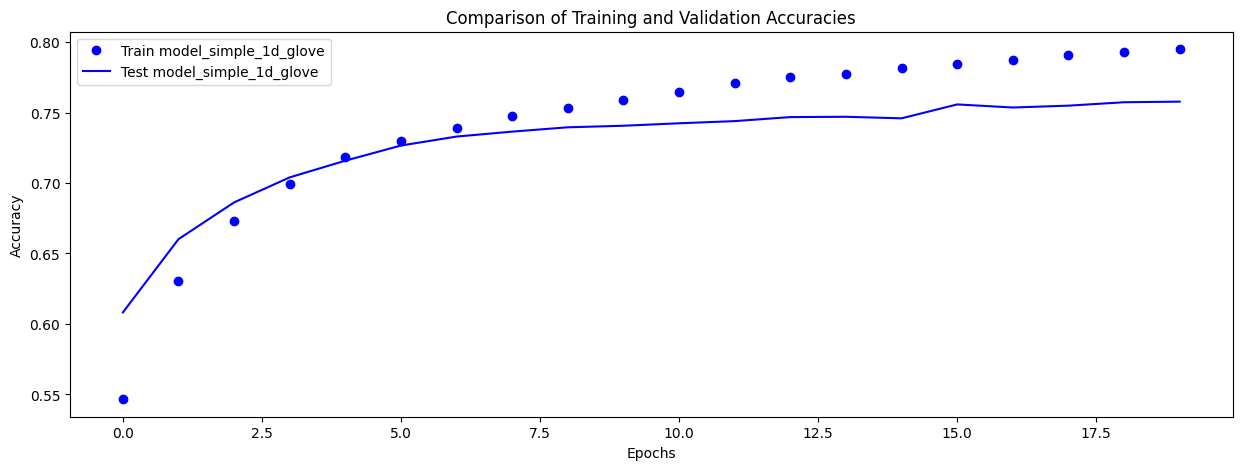

<Figure size 640x480 with 0 Axes>

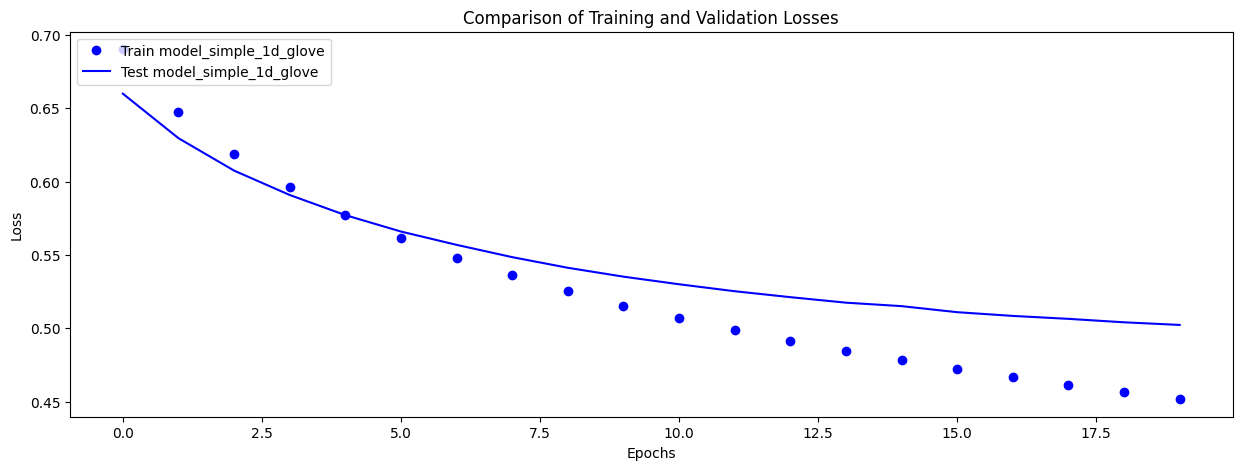

In [44]:
acc_modelSarcasmSimpleRNN_glove = historySarcasmSimpleRNN_glove.history['acc']
val_acc_modelSarcasmSimpleRNN_glove = historySarcasmSimpleRNN_glove.history['val_acc']
loss_modelSarcasmSimpleRNN_glove = historySarcasmSimpleRNN_glove.history['loss']
val_loss_modelSarcasmSimpleRNN_glove = historySarcasmSimpleRNN_glove.history['val_loss']

PlotAccuracyComparison(acc_model_simple_1d_3_glove, val_acc_model_simple_1d_3_glove, lab = 'model_simple_1d_glove')
PlotLossComparison(loss_model_simple_1d_3_glove, val_loss_model_simple_1d_3_glove, lab = 'model_simple_1d_glove')

179/179 [==============================] - 1s 4ms/step


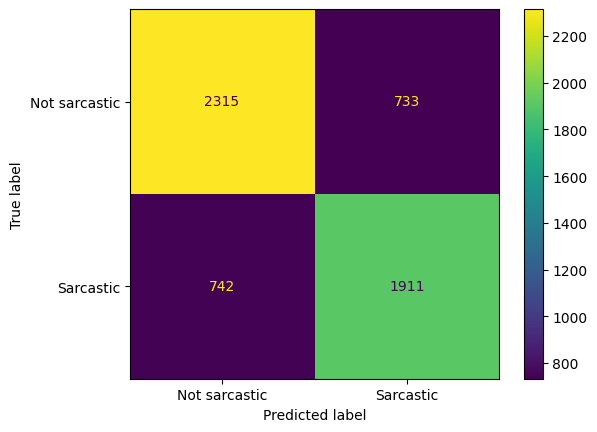

In [45]:
show_confusion_matrix(modelSarcasmSimpleRNN_glove)

* LSTM

In [46]:
modelSarcasmLSTM_glove = Sequential()
modelSarcasmLSTM_glove.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen)) #32
modelSarcasmLSTM_glove.add(layers.LSTM(8)) 
modelSarcasmLSTM_glove.add(layers.Dense(1, activation='sigmoid'))

modelSarcasmLSTM_glove.summary()

modelSarcasmLSTM_glove.layers[0].set_weights([embedding_matrix])
modelSarcasmLSTM_glove.layers[0].trainable = False

modelSarcasmLSTM_glove.compile(optimizer=RMSprop(learning_rate=1e-3),
                      loss='binary_crossentropy',
                      metrics=['acc'])
historySarcasmLSTM_glove = modelSarcasmLSTM_glove.fit(X_train, y_train,
                                    epochs=100,
                                    batch_size=256,
                                    validation_split=0.2)

modelSarcasmLSTM_glove.save(models_dir + 'Sarcasm_LSTM_glove.h5')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 20, 300)           6000000   
                                                                 
 lstm_2 (LSTM)               (None, 8)                 9888      
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 6,009,897
Trainable params: 6,009,897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
72/72 [==============================] - 3s 15ms/step - loss: 0.6404 - acc: 0.6409 - val_loss: 0.5826 - val_acc: 0.7121
Epoch 2/100
72/72 [==============================] - 1s 8ms/step - loss: 0.5544 - acc: 0.7256 - val_loss: 0.5365 - val_acc: 0.7371
Epoch 3/100
72/72 [==========================

<Figure size 640x480 with 0 Axes>

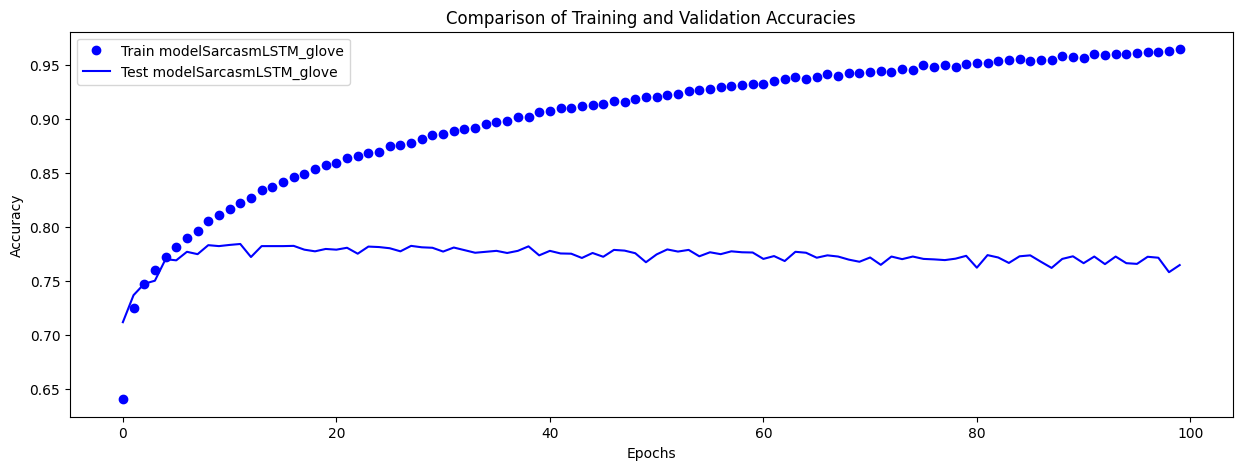

<Figure size 640x480 with 0 Axes>

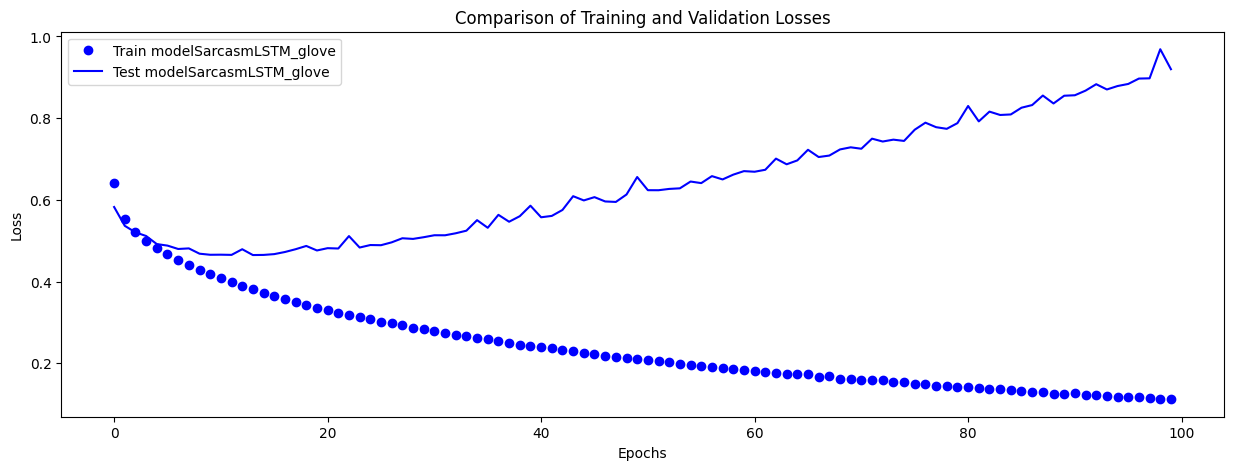

In [47]:
acc_SarcasmLSTM_glove = historySarcasmLSTM_glove.history['acc']
val_acc_SarcasmLSTM_glove = historySarcasmLSTM_glove.history['val_acc']
loss_SarcasmLSTM_glove = historySarcasmLSTM_glove.history['loss']
val_loss_SarcasmLSTM_glove = historySarcasmLSTM_glove.history['val_loss']

PlotAccuracyComparison(acc_SarcasmLSTM_glove, val_acc_SarcasmLSTM_glove, lab = 'modelSarcasmLSTM_glove')
PlotLossComparison(loss_SarcasmLSTM_glove, val_loss_SarcasmLSTM_glove, lab = 'modelSarcasmLSTM_glove')

179/179 [==============================] - 1s 3ms/step


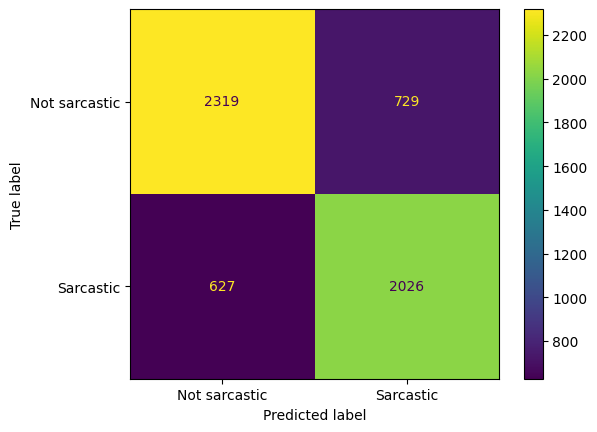

In [48]:
show_confusion_matrix(modelSarcasmLSTM_glove)

Patrząc na wyżej wytrenowane modele przy pomocy warstwy `Embedding` glove widzimy, że sieć 1D convnet gorzej poradziła sobie z dodatkową informacją - osiągnęła gorsze wyniki niż ta bez GloVe. Widzimy natomiast, że lepiej to zadziało na sieci rekurencyjne, nie przetrenowały się, aż w takim stopniu jak wcześniej a osiągnęły podobne wyniki na zbiorze walidacyjnym. Poniżej będziemy to chcieli wykorzystać i rozwinąć model sieci LSTM

### LSTM model

In [55]:
modelSarcasmLSTM_glove = Sequential()
modelSarcasmLSTM_glove.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen)) #32
modelSarcasmLSTM_glove.add(layers.LSTM(128))
modelSarcasmLSTM_glove.add(layers.Dense(64, activation='relu'))
modelSarcasmLSTM_glove.add(layers.Dense(1, activation='sigmoid'))

modelSarcasmLSTM_glove.summary()

modelSarcasmLSTM_glove.layers[0].set_weights([embedding_matrix])
modelSarcasmLSTM_glove.layers[0].trainable = False

modelSarcasmLSTM_glove.compile(optimizer=RMSprop(learning_rate=1e-3),
                      loss='binary_crossentropy',
                      metrics=['acc'])
historySarcasmLSTM_glove = modelSarcasmLSTM_glove.fit(X_train, y_train,
                                    epochs=20,
                                    batch_size=256,
                                    validation_split=0.2)

modelSarcasmLSTM_glove.save(models_dir + 'Sarcasm_LSTM_glove.h5')

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 20, 300)           6000000   
                                                                 
 lstm_7 (LSTM)               (None, 128)               219648    
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6,227,969
Trainable params: 6,227,969
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
72/72 [==============================] - 3s 20ms/step - loss: 0.5619 - acc: 0.7056 - val_loss: 0.5183 - val_acc: 0.7404
Epoch 2/20
72/72 [==========================

In [56]:
modelSarcasmLSTM_glove.evaluate(X_test, y_test)

179/179 [==============================] - 1s 4ms/step - loss: 1.1994 - acc: 0.7872


[1.1993646621704102, 0.7872303128242493]

179/179 [==============================] - 1s 3ms/step


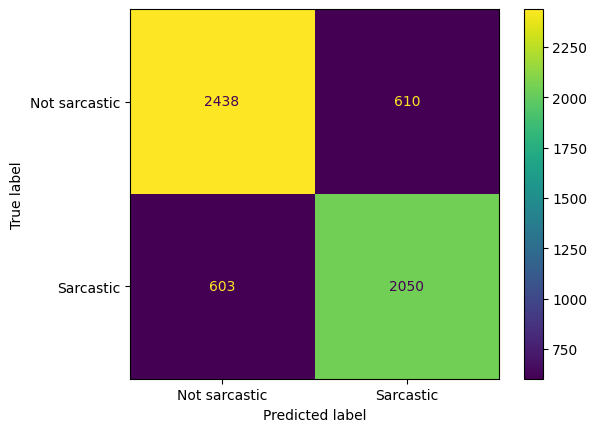

In [57]:
show_confusion_matrix(modelSarcasmLSTM_glove)

## Rezygnacja z lematyzacji
Wcześniej podeszliśmy do problemu jak do typowego problemu przetwarzania języka naturalnego - dokonaliśmy lematyzacji (sprowadzenie słowa do jego podstawowej postaci). Jednak przy wykrywaniu sarkazmu, gdzie każde słowo ma istotny wpływ, lematyzacja może doprowadzić do utraty wiadomości. Zrezygnujmy z niej i wyuczmy nasz najlepszy model na tych danych

In [22]:
df = pd.read_json("dataset/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df = df.drop(columns=['article_link'])
df.drop_duplicates(inplace=True)
df['headline_clean'] = df['headline'].apply(clean_text)
df['headline_clean'] = df['headline_clean'].apply(remove_stopwords)

In [23]:
headers = df['headline_clean']
labels = df['is_sarcastic']
maxlen = 20
test_size = 0.2
max_words = 20000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(headers)
sequences = tokenizer.texts_to_sequences(headers)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, random_state=42)

Found 28644 unique tokens.
Shape of data tensor: (28503, 20)
Shape of label tensor: (28503,)


In [32]:
modelSarcasmLSTM_glove = Sequential()
modelSarcasmLSTM_glove.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen)) #32
modelSarcasmLSTM_glove.add(layers.LSTM(128))
modelSarcasmLSTM_glove.add(layers.Dense(64, activation='relu'))
modelSarcasmLSTM_glove.add(layers.Dense(1, activation='sigmoid'))

modelSarcasmLSTM_glove.summary()

modelSarcasmLSTM_glove.layers[0].set_weights([embedding_matrix])
modelSarcasmLSTM_glove.layers[0].trainable = False

modelSarcasmLSTM_glove.compile(optimizer=RMSprop(learning_rate=1e-3),
                      loss='binary_crossentropy',
                      metrics=['acc'])
historySarcasmLSTM_glove = modelSarcasmLSTM_glove.fit(X_train, y_train,
                                    epochs=20,
                                    batch_size=256,
                                    validation_split=0.2)

modelSarcasmLSTM_glove.save(models_dir + 'Sarcasm_LSTM_glove.h5')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 20, 300)           6000000   
                                                                 
 lstm_4 (LSTM)               (None, 128)               219648    
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,227,969
Trainable params: 6,227,969
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
72/72 [==============================] - 3s 19ms/step - loss: 0.5536 - acc: 0.7176 - val_loss: 0.4909 - val_acc: 0.7628
Epoch 2/20
72/72 [===========================

<Figure size 640x480 with 0 Axes>

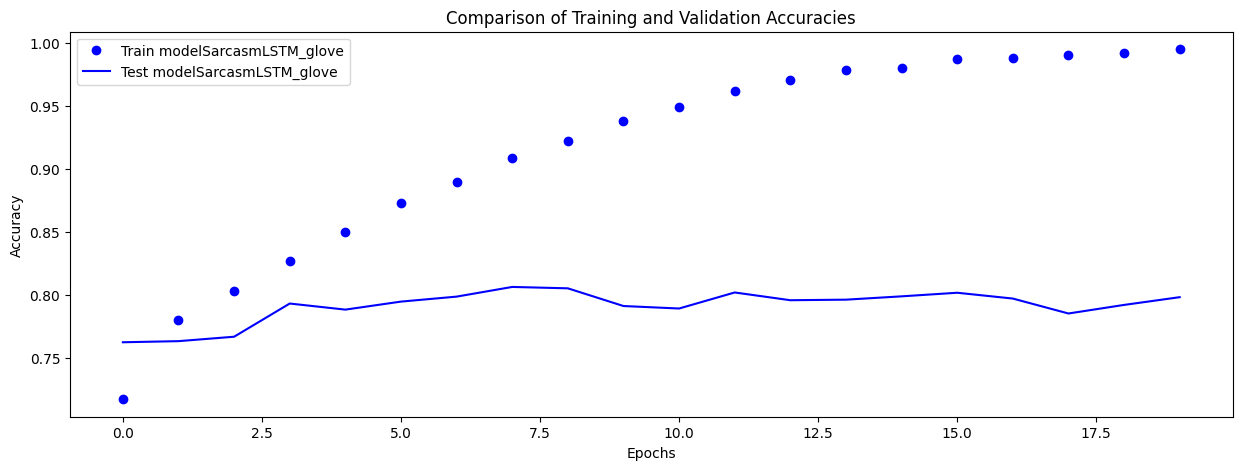

<Figure size 640x480 with 0 Axes>

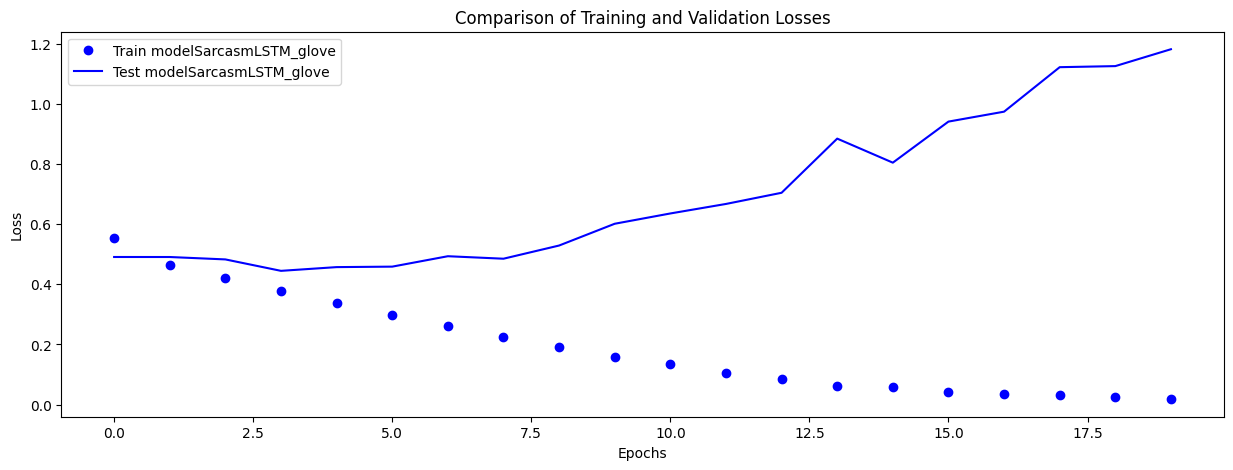

In [33]:
acc_SarcasmLSTM_glove = historySarcasmLSTM_glove.history['acc']
val_acc_SarcasmLSTM_glove = historySarcasmLSTM_glove.history['val_acc']
loss_SarcasmLSTM_glove = historySarcasmLSTM_glove.history['loss']
val_loss_SarcasmLSTM_glove = historySarcasmLSTM_glove.history['val_loss']

PlotAccuracyComparison(acc_SarcasmLSTM_glove, val_acc_SarcasmLSTM_glove, lab = 'modelSarcasmLSTM_glove')
PlotLossComparison(loss_SarcasmLSTM_glove, val_loss_SarcasmLSTM_glove, lab = 'modelSarcasmLSTM_glove')

In [34]:
modelSarcasmLSTM_glove.evaluate(X_test, y_test)

179/179 [==============================] - 1s 4ms/step - loss: 1.1536 - acc: 0.7960


[1.1535929441452026, 0.7960007190704346]

179/179 [==============================] - 1s 3ms/step


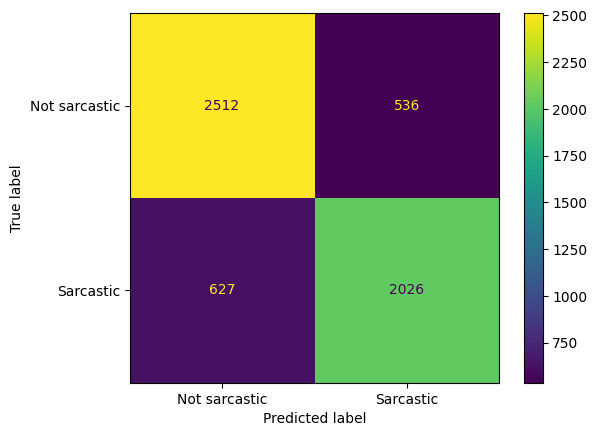

In [35]:
show_confusion_matrix(modelSarcasmLSTM_glove)

Patrząc na powyższe wyniki możemy stwierdzić, że rezygnacja z lematyzacji przyniosła efekt. W problemie wykrywania sarkazmu każdy znak ma znaczenie, tak więc dalsze budowanie modelu będzie oparte na tych danych. Zrobimy to w następnym notebooku, w którym spróbujemy:
- znaleźć odpowiedni model LSTM używając przeszukiwania hiperparametrów (GridSearchCV),
- wypróbować jeszcze bardziej zbudowane modele rekurencyjne: Bidirectional LSTM

### Wnioski z tego notebooka:
- 1D ConvNet pozwala na osiągnięcie w miarę dobrego wyniku, nie przeucza się
- najlepiej spisał się LSTM, jednak towarzyszy mu duży overfitting. Przy czym można spróbować dodać regularyzację modelu
- lematyzacja jest nie potrzebna w tym problemie, prowadzi do utraty ważnych informacji, które ułatwiają wykrycie sarkazmu